In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn import cluster, datasets, preprocessing, metrics

## Part 1: Introduction

The oil and gas industry began testing hydraulic fracturing as a technology since late 1940s (<a href = "http://www.kgs.ku.edu/PRS/Fracturing/Frac_Paper_SPE_152596.pdf">ref</a>). In 1997, Mitchell Energy applied the technology to the Barnett Shale, resulting in greater 90-day production than any previous wells completed by the company (<a href = "https://en.wikipedia.org/wiki/Hydraulic_fracturing#Shales">ref</a>). The development of hydraulic fracturing and horizontal drilling led to the "Shale Boom," and for the first time since the oil export ban in 1973 (following the OPEC oil embargo), the US exported oil (<a href="https://www.forbes.com/sites/rrapier/2017/09/30/why-the-u-s-exports-oil/#58ccc7793b07">ref</a>). Since 2006, the US has been importing less and less crude oil and petroleum products (<a href="https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=WTTNTUS2&f=W">ref</a>). With the growing shale development and the addition of home-grown renewable energy sources, the US is well on its way to energy independence.

Hydraulic fracturing is ubiquitous in 21st century oil and gas development. Nearly all of the new wells in the US are horizontal, hydraulically fractured wells. These days, horizontal wells can extend over 15,000' long (laterally) and contain more than 40 stages. A stage describes a short section of the lateral portion of the wellbore to be frac'ed. For more information on how fracing works, see this <a href="https://youtu.be/VY34PQUiwOQ?t=2m46s">YouTube video</a>.

In a hydraulic fracturing (or "frac") job, each stage will generate a "pump curve." A pump curve describes the concentration of sand pumped over time (or as a proxy for time, cumulative volume pumped; the more time passes, the greater the cumulative volume). 

Below is a sample a pump curve for a single well looks like.

Text(0,0.5,'Concentration')

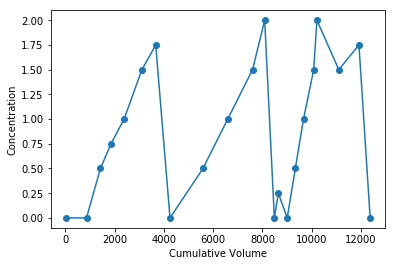

In [4]:
# Sample Data
x = [15.8,857.2,1422.3,1852.7,2383.1,3108.1,3667.9,4248.6,5585.9,6592.1,7600.7,8093.4,8486.7,8647.1,9009.1,9337.1,9670.1,10084.1,10215.2,11104.2,11922.2,12377]
y = [0,0,0.5,0.75,1,1.5,1.75,0,0.5,1,1.5,2,0,0.25,0,0.5,1,1.5,2,1.5,1.75,0]
plt.plot(x,y,'o-')
plt.xlabel('Cumulative Volume')
plt.ylabel('Concentration')

As you can see, there is a pattern of "ramps" (when concentration increases).

**Objective:** I would like to capture the pattern of these ramps and run a clustering algorithm them to find "pump curve families."

*Secondary Objective:* I will use the pump curve famililies, in addition to some other features in a regression tree or other classification model to determine which pump curve family results in high 180-day cumulative oil production.

In [5]:
# Function to determine whether the pump schedule is ramping up
# Count the number of ramps
# Writing the code to see if I can determine the "ramp status" of the pump curve to be used later

def tot_ramp(conc): # Where conc is an list
    concl = list(y)
    ramping = 0
    ramp_count = 0

    for i, num in enumerate(concl): # Loop through data
        if i == len(concl)-1: # Out of bounds condition
            break
        if num > concl[i-1] and num >= concl[i+1]: # End ramp condition
            ramping += 1
            if ramping == 1: ramp_count +=1 # Count ramp
            ramping = 0
        elif num < concl[i+1]: # Ramping condition
            ramping += 1
            if ramping == 1: ramp_count +=1 # Count ramp
    return ramp_count

# Test function on  sample data from above
tot_ramp(y)

5

## Part 2: Exploratory Data Analysis

- What does the distribution look like for max cum fluid?

In [6]:
# Read in data
pump = pd.read_table('./pump_schedule_designs.csv', sep=',')
pump.head()

WELL_ID FLUID_ID VOLUME  CONC  RATE SAND_ID   CUM_FLUID Interpreter
0     1000        A   1000   0.0    15     NaN    0.000000         kjw
1     1000        A    500   0.0    15     NaN   23.809524         kjw
2     1000        S   4000   0.0    15     NaN   35.714286         kjw
3     1000        A  20000   0.0   100     NaN  130.952381         kjw
4     1000        A   8000   0.5   100       R  607.142857         kjw

This data table contains the pump schedule for multiple wells. Each well is designated by its `WELL_ID`. The columns of interest are `CUM_FLUID` and `CON`.

In [70]:
# Determine data types
pump.dtypes

# Change WELL_ID from integer to string
pump['WELL_ID'] = pump['WELL_ID'].astype(str)
pump.dtypes

WELL_ID         object
FLUID_ID        object
VOLUME          object
CONC           float64
RATE             int64
SAND_ID         object
CUM_FLUID      float64
Interpreter     object
dtype: object

In [71]:
# Check the data table
pump.describe()

CONC          RATE     CUM_FLUID
count  17719.000000  17719.000000  17719.000000
mean       0.912496     77.604831   4653.466161
std        0.971781     29.944965   3523.198324
min        0.000000      0.000000      0.000000
25%        0.000000     80.000000   1696.714286
50%        0.750000     90.000000   4285.714286
75%        1.500000    100.000000   7104.142857
max        9.000000    100.000000  22628.833330

Notice that there is some missing data in the `CONC` column.

In [72]:
# Replace all NaN values in CONC column with zeroes.
pump['CONC'].replace(np.nan, 0, inplace=True)

In [73]:
# How many wells are in the data set?
pump['WELL_ID'].nunique()

840

In [74]:
# Double-check
len(pump['WELL_ID'].value_counts())

840

In [75]:
# Store it
num_wells = pump['WELL_ID'].nunique()

In [76]:
# Get array of wells
wells = pump['WELL_ID'].unique()
wells[0]

'1000'

In [77]:
# Get the max cum volume for each well
pump_maxcum = pd.DataFrame(pump.groupby('WELL_ID')[['WELL_ID','CUM_FLUID']].max())

# Change the column name
pump_maxcum.rename(index=str, columns={'CUM_FLUID':'MAX_FLUID'}, inplace=True)
# pump_maxcum.head(10)

# Join values of pump_maxcum to pump
pump_final = pd.merge(pump, pump_maxcum, on='WELL_ID', how='left')

# Calculate fraction of job by CUM_FLUID_BBL pumped. Normalize data.
pump_final['JOB_FRAC'] = pump_final['CUM_FLUID'] / pump_final['MAX_FLUID']

# Convert CUM_FLUID to different unit
pump_final['CUM_FLUID_UNIT'] = pump_final['CUM_FLUID']*42/10000

pump_final.head(10)

WELL_ID FLUID_ID VOLUME  CONC  RATE SAND_ID    CUM_FLUID Interpreter  \
0    1000        A   1000  0.00    15     NaN     0.000000         kjw   
1    1000        A    500  0.00    15     NaN    23.809524         kjw   
2    1000        S   4000  0.00    15     NaN    35.714286         kjw   
3    1000        A  20000  0.00   100     NaN   130.952381         kjw   
4    1000        A   8000  0.50   100       R   607.142857         kjw   
5    1000        A   8000  0.75   100       R   797.619048         kjw   
6    1000        A  12000  1.00   100       R   988.095238         kjw   
7    1000        A  12000  1.50   100       R  1273.809524         kjw   
8    1000        A  10000  2.00   100       R  1559.523810         kjw   
9    1000        A   8000  2.50   100       R  1797.619048         kjw   

     MAX_FLUID  JOB_FRAC  CUM_FLUID_UNIT  
0  6964.547619  0.000000            0.00  
1  6964.547619  0.003419            0.10  
2  6964.547619  0.005128            0.15  
3  6964.547619  0.018803            0.55  
4  6964.547619  0.087176            2.55  
5  6964.547619  0.114526            3.35  
6  6964.547619  0.141875            4.15  
7  6964.547619  0.182899            5.35  
8  6964.547619  0.223923            6.55  
9  6964.547619  0.258110            7.55

I am interested in characterizing the ramp by slope and initiation point. In order to do that, I have to determine whether or not the pump curve is ramping (when concentration increases from the previous step).

In [78]:
# Determine the total number of ramps for each well

# Initiate empty data frame to store data
ramps = pd.DataFrame(columns = ['WELL_ID','TOT_RAMPS'])

# Loop through wells and extract concentration curve for each well
for i in range(0,num_wells):
    y = pump_final[pump_final['WELL_ID']==wells[i]].CONC
    # Return ramp count using tot_ramp() function
    ramps = ramps.append({'WELL_ID': wells[i], 'TOT_RAMPS': tot_ramp(y)}, ignore_index=True)

In [79]:
# Store frequency count for each uniqe number of ramps into data frame
count_ramps = pd.DataFrame(ramps['TOT_RAMPS'].value_counts())

# Rename the column
count_ramps.rename(index=int, columns={'TOT_RAMPS':'WELL_COUNT'}, inplace=True)

# Store index into an array called "values"
values = np.sort(np.array(count_ramps.index))

# Display data frame sorted on index values
count_ramps.sort_index(axis=0)

# What is the most prevalent value of ramps? (Ans: 2)

WELL_COUNT
1           52
2          323
3          174
4          140
5           38
6           34
7           22
8           24
9            6
10           5
13           2
14          15
15           1
16           1
17           1
21           2

Text(0.5,1,'Wells with Specified Number of Ramps')

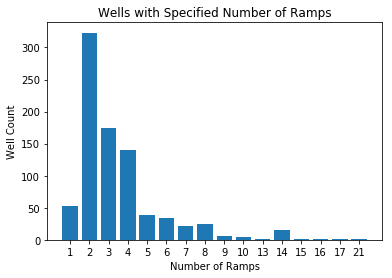

In [80]:
# Attempted to plot histogram.
frequency = count_ramps['WELL_COUNT'].sort_index(axis=0)
y_pos = np.arange(len(frequency))

plt.bar(y_pos, list(frequency))
plt.xticks(y_pos, values)
plt.xlabel('Number of Ramps')
plt.ylabel('Well Count')
plt.title('Wells with Specified Number of Ramps')

In [81]:
pump_final

WELL_ID FLUID_ID  VOLUME  CONC  RATE SAND_ID    CUM_FLUID Interpreter  \
0        1000        A    1000  0.00    15     NaN     0.000000         kjw   
1        1000        A     500  0.00    15     NaN    23.809524         kjw   
2        1000        S    4000  0.00    15     NaN    35.714286         kjw   
3        1000        A   20000  0.00   100     NaN   130.952381         kjw   
4        1000        A    8000  0.50   100       R   607.142857         kjw   
5        1000        A    8000  0.75   100       R   797.619048         kjw   
6        1000        A   12000  1.00   100       R   988.095238         kjw   
7        1000        A   12000  1.50   100       R  1273.809524         kjw   
8        1000        A   10000  2.00   100       R  1559.523810         kjw   
9        1000        A    8000  2.50   100       R  1797.619048         kjw   
10       1000        A    6000  0.00   100     NaN  1988.095238         kjw   
11       1000        A    8000  0.25   100       Q  2130.952381         kjw   
12       1000        A   10000  0.50   100       Q  2321.428571         kjw   
13       1000        A   18000  0.75   100       Q  2559.523810         kjw   
14       1000        A   20000  1.00   100       Q  2988.095238         kjw   
15       1000        A   20000  1.25   100       Q  3464.285714         kjw   
16       1000        A    6000  0.50   100       Q  3940.476190         kjw   
17       1000        A   20000  1.50   100       Q  4083.333333         kjw   
18       1000        A    6000  0.50   100       Q  4559.523810         kjw   
19       1000        A   18000  1.75   100       Q  4702.380952         kjw   
20       1000        A    6000  0.50   100       Q  5130.952381         kjw   
21       1000        A   12000  2.00   100       Q  5273.809524         kjw   
22       1000        D   10000  0.50   100      ES  5559.523810         kjw   
23       1000        D   12000  1.00   100      ES  5797.619048         kjw   
24       1000        D   12000  1.50   100      ES  6083.333333         kjw   
25       1000        D   12500  2.00   100      ES  6369.047619         kjw   
26       1000        A   12511  0.00   100     NaN  6666.666667         kjw   
27       1000        A       0  0.00     0     NaN  6964.547619         kjw   
28       1001        A    1000  0.00    15     NaN     0.000000         kjw   
29       1001        S    1000  0.00    20     NaN    23.809524         kjw   
...       ...      ...     ...   ...   ...     ...          ...         ...   
17689    1838        A  20,034  0.50    95       Q  4881.000000         kjw   
17690    1838        A  29,988  0.75    95       Q  5358.000000         kjw   
17691    1838        A  35,952  1.00    95       Q  6072.000000         kjw   
17692    1838        A  27,048  1.25    95       Q  6928.000000         kjw   
17693    1838        A  24,990  1.50    95       Q  7572.000000         kjw   
17694    1838        A  22,050  2.00    95       Q  8167.000000         kjw   
17695    1838        A  22,050  1.88    95       Q  8692.000000         kjw   
17696    1838        A  16,464  0.00    95     NaN  9217.000000         kjw   
17697    1838        A       0  0.00     0     NaN  9609.000000         kjw   
17698    1839        A     840  0.00    10     NaN     0.000000         kjw   
17699    1839        S   1,008  0.00    10     NaN    20.000000         kjw   
17700    1839        A  21,126  0.00    95     NaN    44.000000         kjw   
17701    1839        A  19,950  0.25    95       R   547.000000         kjw   
17702    1839        A  20,034  0.50    95       R  1022.000000         kjw   
17703    1839        A  24,990  1.00    95       R  1499.000000         kjw   
17704    1839        A  27,510  1.50    95       R  2094.000000         kjw   
17705    1839        A  35,910  2.00    95       R  2749.000000         kjw   
17706    1839        A  14,742  0.00    95     NaN  3604.000000         kjw   
17707    1839        G     336  0.00    10     NaN  3955

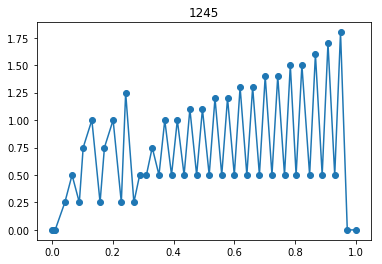

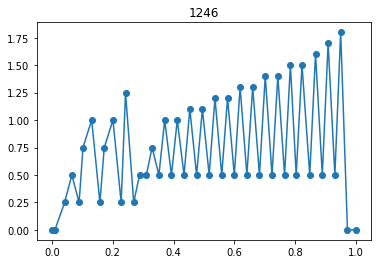

In [20]:
# What do the pump curves with higher (>= 9) ramps look like?
# hi_ramps = ramps[ramps['TOT_RAMPS'] >= 9].index.values
hi_ramps = ramps[ramps['TOT_RAMPS'] == 21].index.values

for i in hi_ramps:
    x = pump_final[pump_final['WELL_ID']==wells[i]].JOB_FRAC
    y = pump_final[pump_final['WELL_ID']==wells[i]].CONC
    plt.figure()
    plt.plot(x,y,'o-')
    plt.title(wells[i])

In [21]:
hi_ramps[0]

245

## Part 3: Data Preparation

**OBJECTIVE:** Get slope and initiation points for each ramp in the pump schedule and store in a data frame.

In [105]:
# Initiate a list of lists to store slope and initation point
data = []

# Instantiate linear regression model
lr = LinearRegression()

# Limit table to only the first half of the pump schedule
# pump_final = pump_final[pump_final['JOB_FRAC']<=0.5]

#### BEGIN LOOP ####
w_max = len(wells)

for w in range(0,w_max):
    # Extract pump curve for well i
    x = pump_final[pump_final['WELL_ID']==wells[w]].CUM_FLUID_UNIT
    y = pump_final[pump_final['WELL_ID']==wells[w]].CONC

    # Store x- and y-values for each ramp in a list of lists (fractions and concs)
    fraction = list(x)
    conc = list(y)
    fractions = [[] for x in range(0,tot_ramp(y))] # initiate blank list of lists
    concs = [[] for x in range(0,tot_ramp(y))] # initiate blank list of lists

    ramping = 0 # Counts the number of steps while ramping
    ramp_count = 0 # Counts the number of ramps


    for i, num in enumerate(conc): # Loop through data
        if i == len(conc)-1: # Out of bounds condition
            break
        if num > conc[i-1] and num >= conc[i+1]: # End ramp condition
            ramping += 1
            status = 2
            if ramping == 1: ramp_count +=1 # Count ramp
            concs[ramp_count-1].append(num) # Append concentration to list
            fractions[ramp_count-1].append(fraction[i]) # Append fraction to list
            # Reset ramp status
            status = 0
            ramping = 0
        elif num < conc[i+1]: # Ramping condition
            ramping += 1
            status = 1
            if ramping == 1: ramp_count +=1 # Count ramp
            concs[ramp_count-1].append(num) # Append concentration to list
            fractions[ramp_count-1].append(fraction[i]) # Append fraction to list
        else:
            ramping = 0
            status = 0

    # Fit a line to each ramp
    data_sub = [] # List containing slope and initiation point for each ramp

    for i in range(0,ramp_count): # Loop through each ramp
        X_test = np.array(fractions[i]).reshape(-1,1)
        y_test = np.array(concs[i])

        data_sub.append(fractions[i][0])

        lr.fit(X_test, y_test)
        data_sub.append(lr.coef_[0])

    data.append(data_sub)
    print('Well {} of {} completed.'.format(w+1, w_max))
### END LOOP ###

Well 1 of 840 completed.
Well 2 of 840 completed.
Well 3 of 840 completed.
Well 4 of 840 completed.
Well 5 of 840 completed.
Well 6 of 840 completed.
Well 7 of 840 completed.
Well 8 of 840 completed.
Well 9 of 840 completed.
Well 10 of 840 completed.
Well 11 of 840 completed.
Well 12 of 840 completed.
Well 13 of 840 completed.
Well 14 of 840 completed.
Well 15 of 840 completed.
Well 16 of 840 completed.
Well 17 of 840 completed.
Well 18 of 840 completed.
Well 19 of 840 completed.
Well 20 of 840 completed.
Well 21 of 840 completed.
Well 22 of 840 completed.
Well 23 of 840 completed.
Well 24 of 840 completed.
Well 25 of 840 completed.
Well 26 of 840 completed.
Well 27 of 840 completed.
Well 28 of 840 completed.
Well 29 of 840 completed.
Well 30 of 840 completed.
Well 31 of 840 completed.
Well 32 of 840 completed.
Well 33 of 840 completed.
Well 34 of 840 completed.
Well 35 of 840 completed.
Well 36 of 840 completed.
Well 37 of 840 completed.
Well 38 of 840 completed.
Well 39 of 840 comple

Well 311 of 840 completed.
Well 312 of 840 completed.
Well 313 of 840 completed.
Well 314 of 840 completed.
Well 315 of 840 completed.
Well 316 of 840 completed.
Well 317 of 840 completed.
Well 318 of 840 completed.
Well 319 of 840 completed.
Well 320 of 840 completed.
Well 321 of 840 completed.
Well 322 of 840 completed.
Well 323 of 840 completed.
Well 324 of 840 completed.
Well 325 of 840 completed.
Well 326 of 840 completed.
Well 327 of 840 completed.
Well 328 of 840 completed.
Well 329 of 840 completed.
Well 330 of 840 completed.
Well 331 of 840 completed.
Well 332 of 840 completed.
Well 333 of 840 completed.
Well 334 of 840 completed.
Well 335 of 840 completed.
Well 336 of 840 completed.
Well 337 of 840 completed.
Well 338 of 840 completed.
Well 339 of 840 completed.
Well 340 of 840 completed.
Well 341 of 840 completed.
Well 342 of 840 completed.
Well 343 of 840 completed.
Well 344 of 840 completed.
Well 345 of 840 completed.
Well 346 of 840 completed.
Well 347 of 840 completed.
W

Well 633 of 840 completed.
Well 634 of 840 completed.
Well 635 of 840 completed.
Well 636 of 840 completed.
Well 637 of 840 completed.
Well 638 of 840 completed.
Well 639 of 840 completed.
Well 640 of 840 completed.
Well 641 of 840 completed.
Well 642 of 840 completed.
Well 643 of 840 completed.
Well 644 of 840 completed.
Well 645 of 840 completed.
Well 646 of 840 completed.
Well 647 of 840 completed.
Well 648 of 840 completed.
Well 649 of 840 completed.
Well 650 of 840 completed.
Well 651 of 840 completed.
Well 652 of 840 completed.
Well 653 of 840 completed.
Well 654 of 840 completed.
Well 655 of 840 completed.
Well 656 of 840 completed.
Well 657 of 840 completed.
Well 658 of 840 completed.
Well 659 of 840 completed.
Well 660 of 840 completed.
Well 661 of 840 completed.
Well 662 of 840 completed.
Well 663 of 840 completed.
Well 664 of 840 completed.
Well 665 of 840 completed.
Well 666 of 840 completed.
Well 667 of 840 completed.
Well 668 of 840 completed.
Well 669 of 840 completed.
W

In [106]:
# Create data frame from slope and initatiation point data
data_df = pd.DataFrame(data)

# Replace all NaN values with zeroes
data_df.replace(np.nan, 0, inplace=True)

# Define column names
col_names = []
count = 1
for i in range(len(data_df.columns)):
    if (i+1) % 2 == 0: # Even (Slopes)
        col_names.append('m'+ str(count))
        count +=1
    else: # Odd (Initiation Points)
        col_names.append('i'+ str(count))
        
data_df.columns = col_names

# Reassign index to well id
data_df.set_index(wells, inplace=True)

In [108]:
data_df.head()

i1        m1     i2        m2   i3   m3   i4   m4   i5   m5   i6   m6  \
1000  0.55  0.360048   8.35  0.233346  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1001  0.20  0.110414  12.00  0.069444  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1002  0.20  0.222222   7.40  0.138889  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1003  0.20  0.222222   7.40  0.138889  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1004  0.20  0.222222   7.40  0.138889  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       i7   m7   i8   m8   i9   m9  i10  m10  
1000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1001  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1002  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1003  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1004  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [111]:
# Export values to csv
pd.DataFrame.to_csv(data_df,'pump_schedule_slopes.csv', index=True)

### K-Means Clustering

In [65]:
# Class to run k-means model by taking in the data as a pandas data frame.
class kmeansModel:
    def __init__(self, df):
        self.df = df
        self.inertia = None
        self.silhouette = None
        self.labels = None
    
    def runModel(self, n):
        # Scale the data
        df_sc = preprocessing.MinMaxScaler().fit_transform(self.df)
        
        # Use k-means clustering
        kmeans = KMeans(n_clusters=n, random_state=0).fit(df_sc)
        
        # Calculate metrics
        self.labels = kmeans.labels_
        labels_arr = pd.Series(kmeans.labels_)
        centroids = kmeans.cluster_centers_
        self.inertia = kmeans.inertia_
        self.silhouette = metrics.silhouette_score(df_sc, self.labels, metric='euclidean')
        
        print("Silhouette:", self.silhouette)
        print("Inertia:", self.inertia)
    
    def optimize(self, nmin, nmax):
        inertias = []
        silhouettes = []
        df_sc = preprocessing.MinMaxScaler().fit_transform(self.df)

        for i in range(nmin, nmax):
            kmeans = KMeans(n_clusters=i, random_state=0).fit(df_sc)
            labels = kmeans.labels_
            inertias.append(kmeans.inertia_)
            silhouettes.append(metrics.silhouette_score(df_sc, labels, metric='euclidean'))
        
        # Plot the inertias and silouettes
        fig, iner = plt.subplots()
        ax1 = iner.plot(range(2,20),inertias,'ro-', label='inertia')
        iner.set_xlabel('k')
        iner.set_ylabel('Inertia')

        sil = iner.twinx()
        ax2 = sil.plot(range(2,20),silhouettes,'bo-', label='silhouette')
        sil.set_ylabel('Silhouette')
        iner.legend()

        lns = ax1+ax2
        labs = ['inertia','silhouette']
        iner.legend(lns, labs, loc=0)

        plt.show()

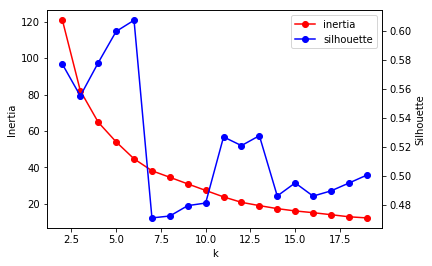

In [66]:
allData = kmeansModel(data_df)
allData.optimize(2,20)

In [67]:
allData.runModel(6)

Silhouette: 0.6074899048565082
Inertia: 44.626236835728825


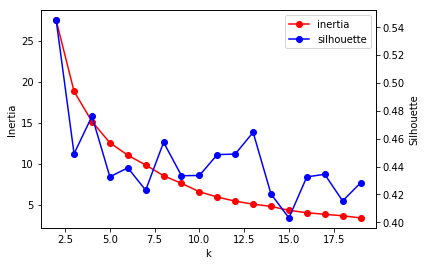

In [91]:
firstTwoSlopes = kmeansModel(data_df.iloc[:,0:4])
firstTwoSlopes.optimize(2,20)

In [92]:
firstTwoSlopes.runModel(3)

Silhouette: 0.4492524042646395
Inertia: 18.811643435046253


**Note:** We want a high silhouette (ranges from -1 to 1, close to 1 is better; clusters are far apart) and a low inertia (clusters are dense)

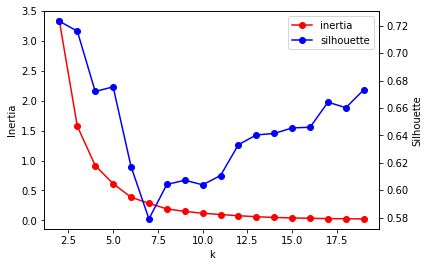

In [93]:
firstSlope = kmeansModel(data_df.iloc[:,0:1])
firstSlope.optimize(2,20)

In [96]:
firstSlope.runModel(3)

Silhouette: 0.7160618267816107
Inertia: 1.5740000264345912


The first Slope model gives us the best inertia and silhouette values.

In [97]:
# Create a dataframe with wells and labels
category_df = pd.DataFrame(firstSlope.labels)
category_df['WELL_ID'] = wells

# Export labels to csv
pd.DataFrame.to_csv(category_df,'pump_schedule_cat_firstSlope.csv', index=False)

In [99]:
pump_category = pd.merge(pump_final, category_df, on='WELL_ID', how='left')
pump_category.rename(index=int, columns={0:'CATEGORY'}, inplace=True)

In [109]:
cat = 0

# Get well list in category as series
well_series = pump_category[pump_category['CATEGORY']==cat]['WELL_ID'].value_counts()

# Convert series into list
well_list = list(well_series.index.values) 
len(well_list)

648

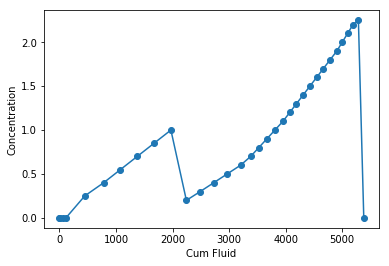

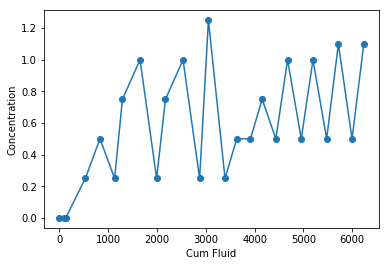

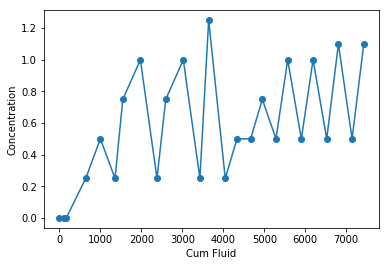

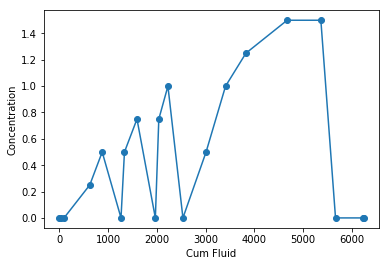

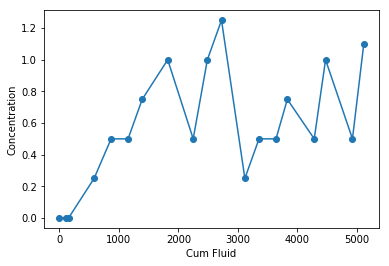

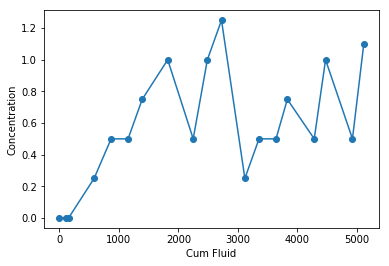

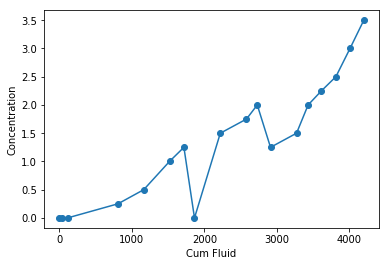

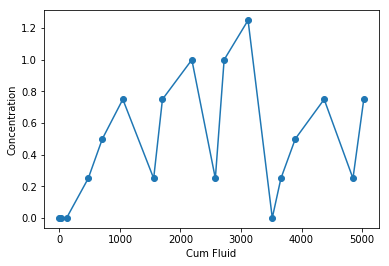

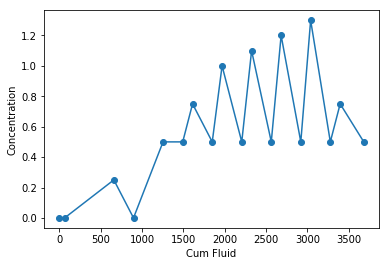

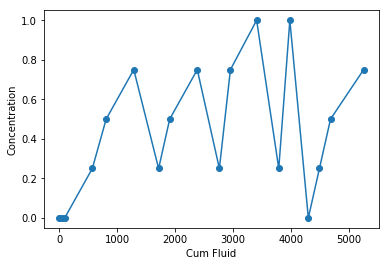

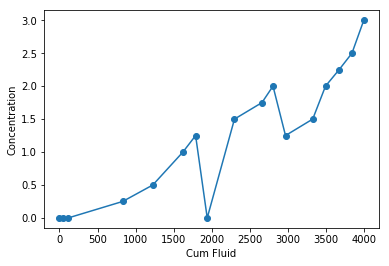

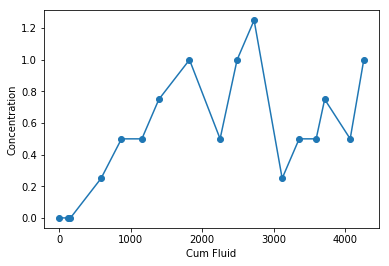

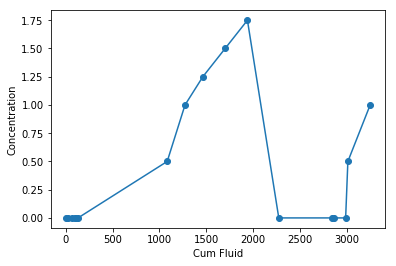

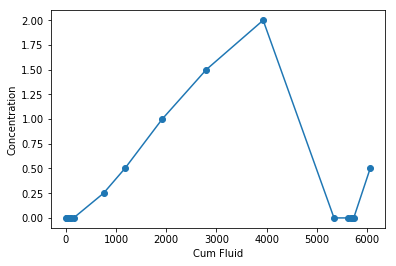

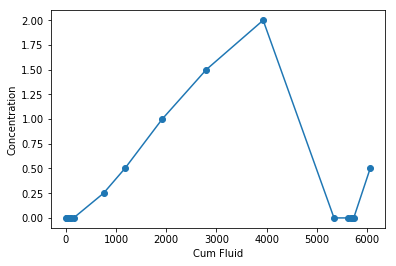

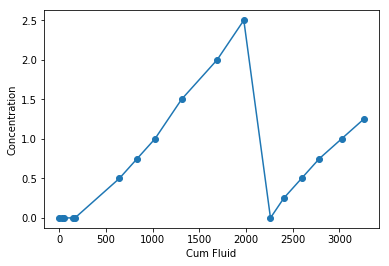

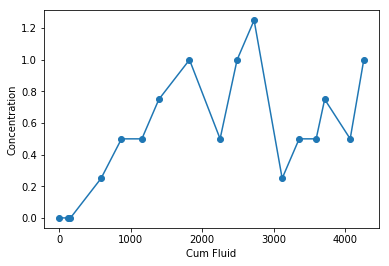

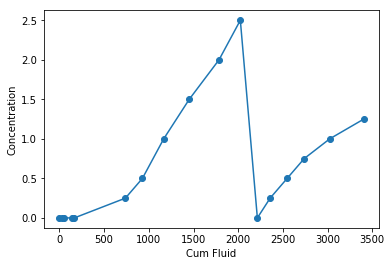

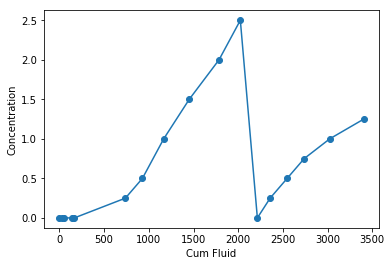

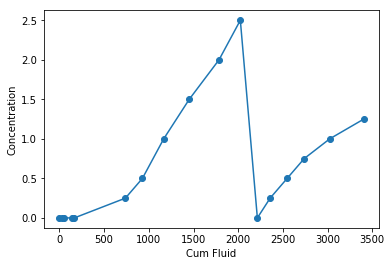

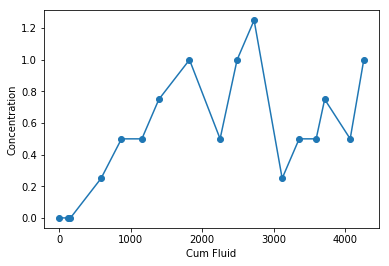

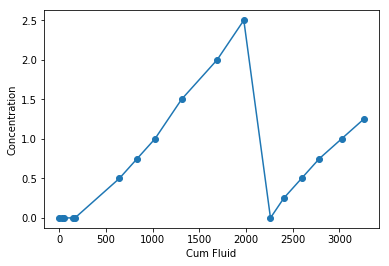

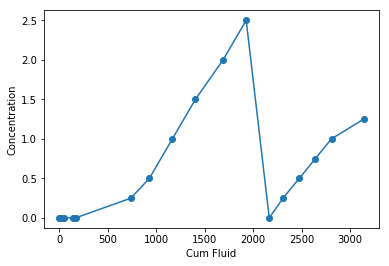

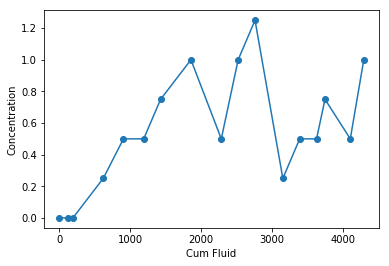

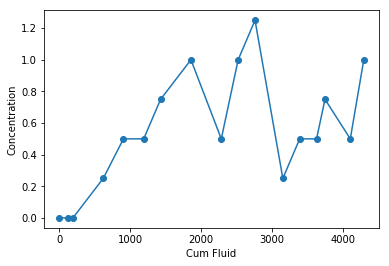

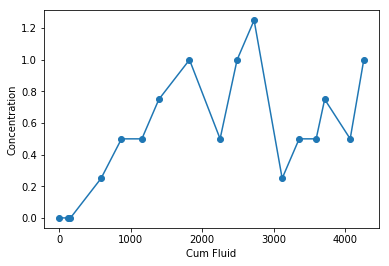

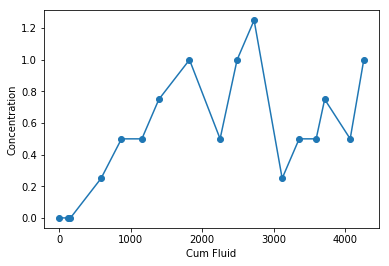

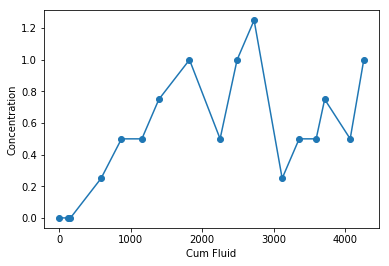

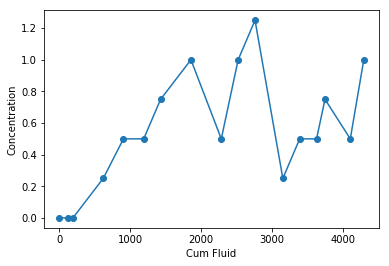

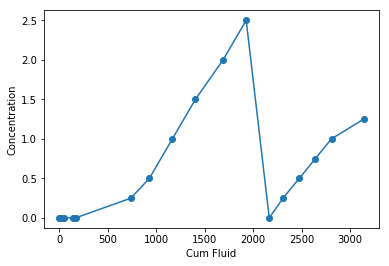

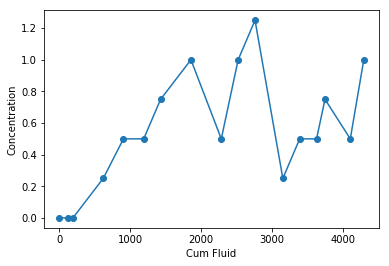

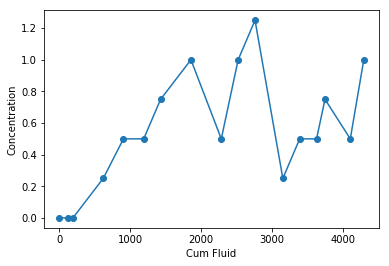

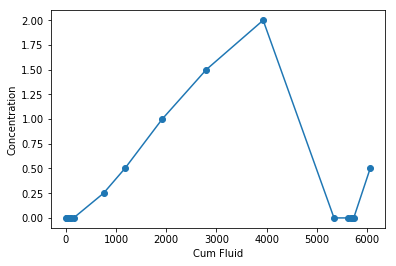

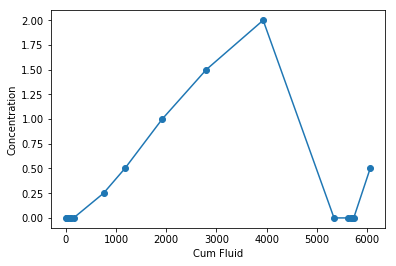

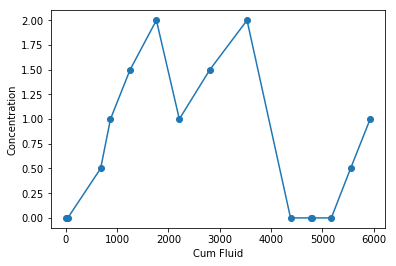

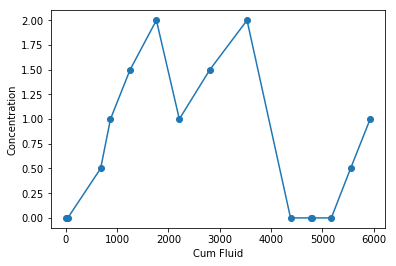

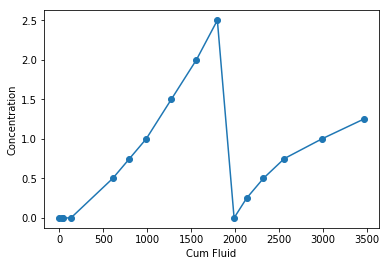

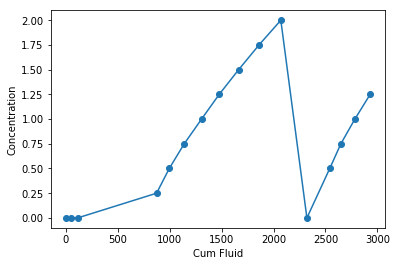

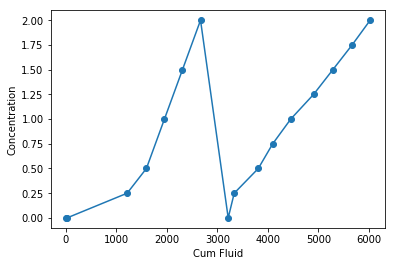

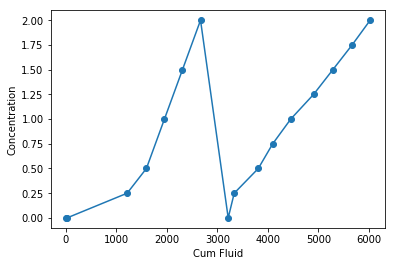

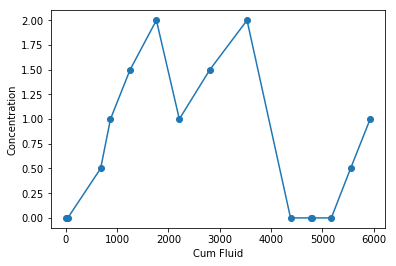

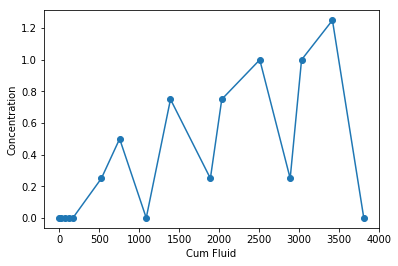

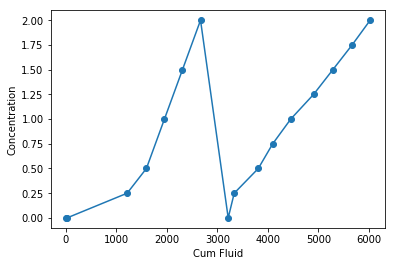

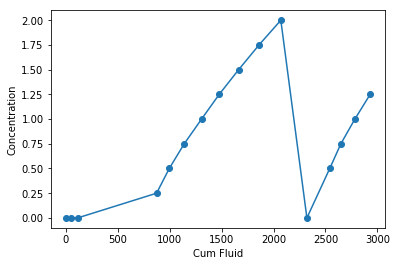

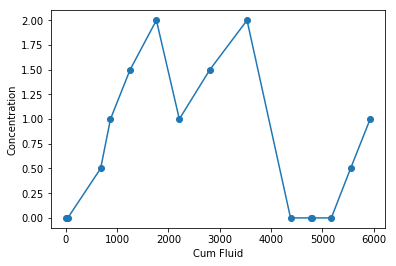

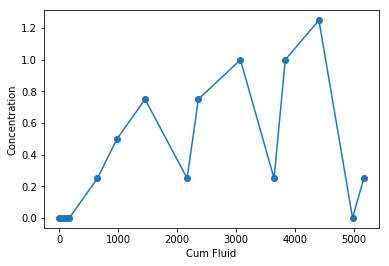

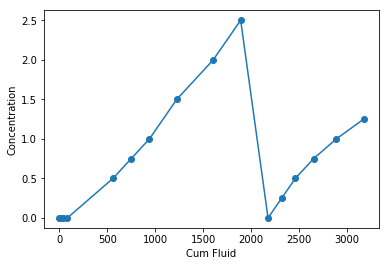

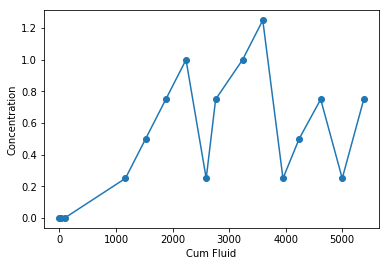

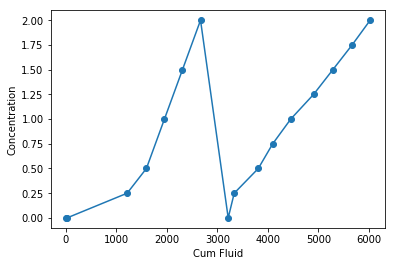

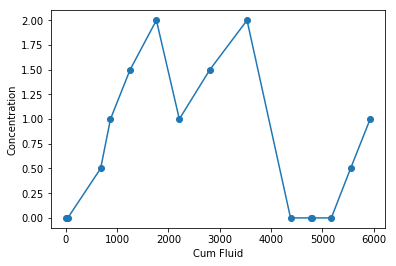

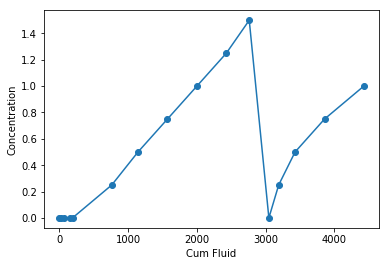

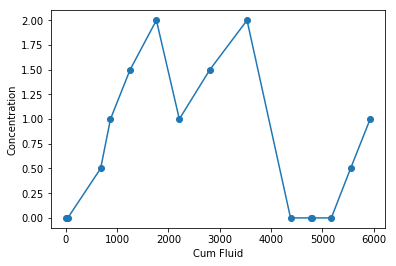

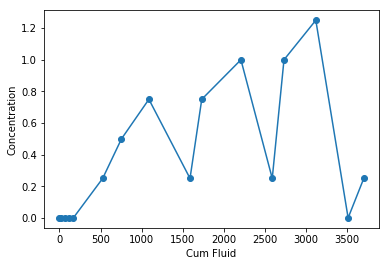

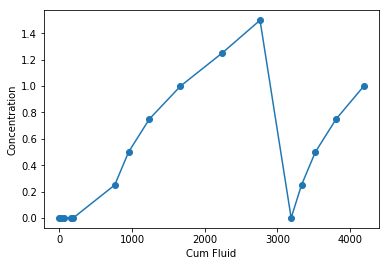

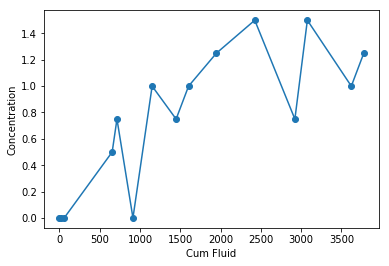

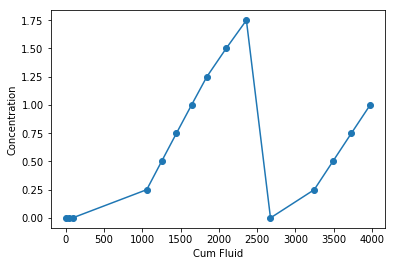

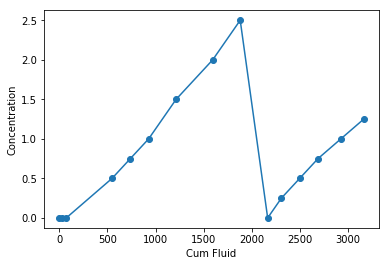

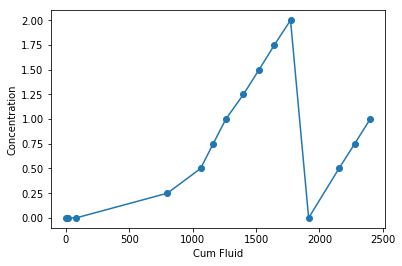

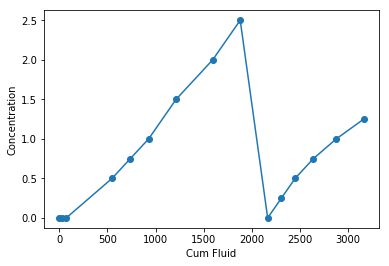

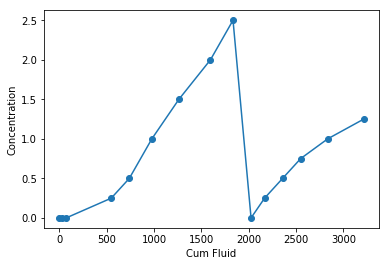

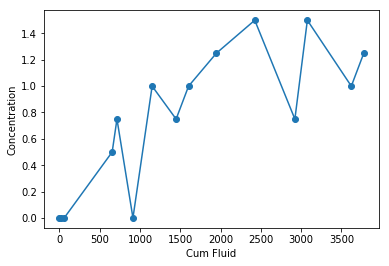

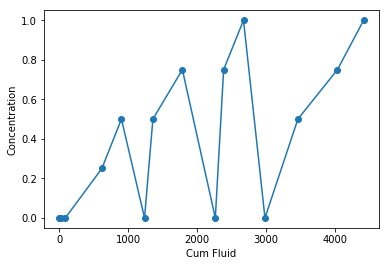

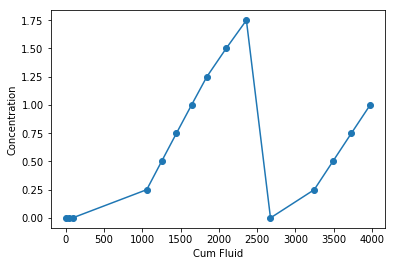

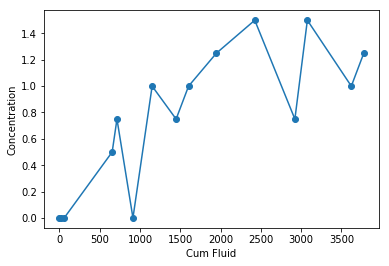

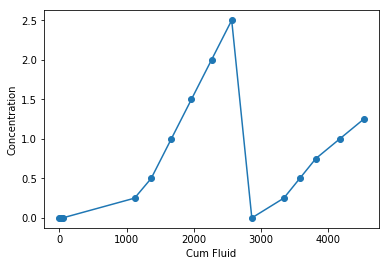

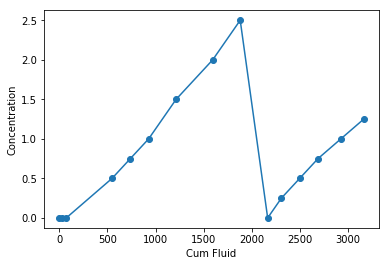

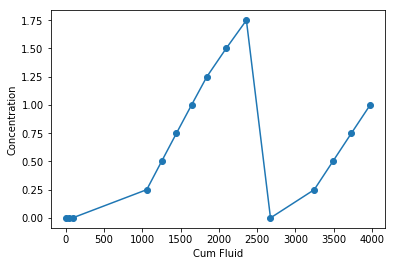

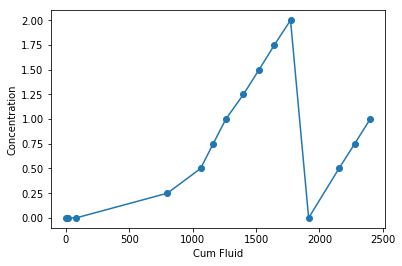

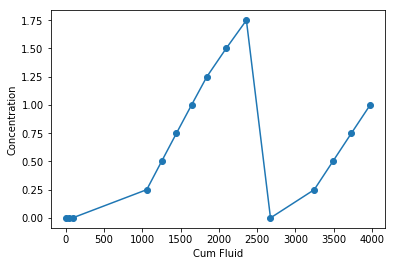

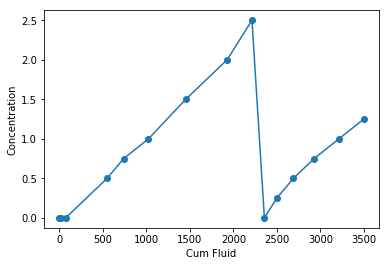

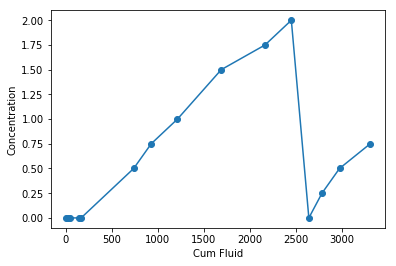

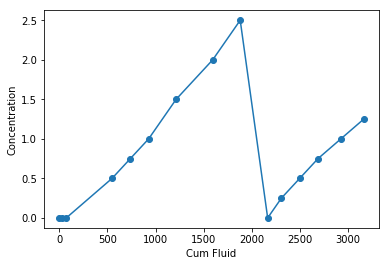

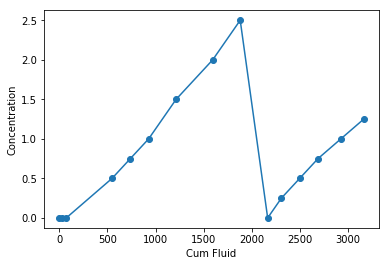

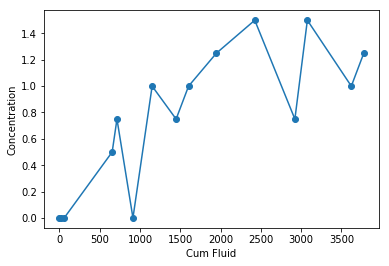

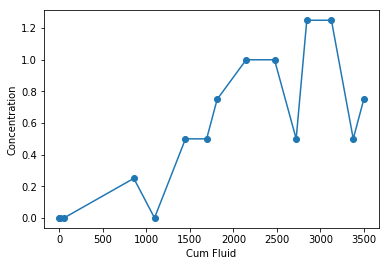

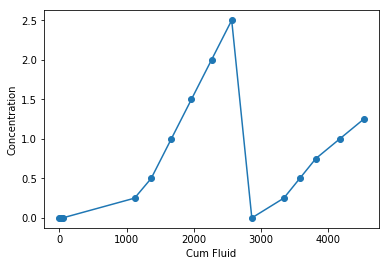

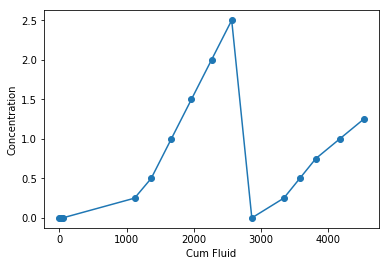

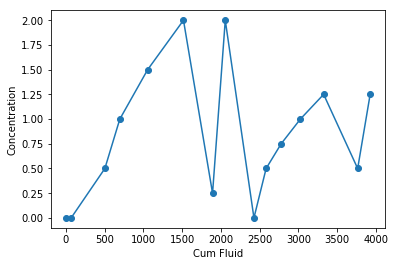

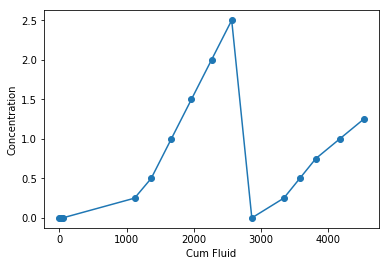

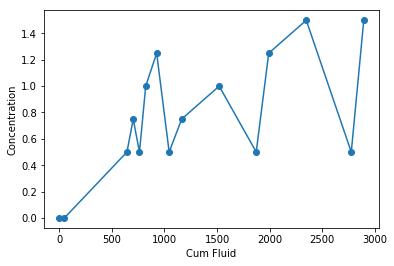

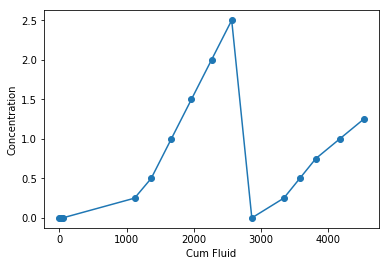

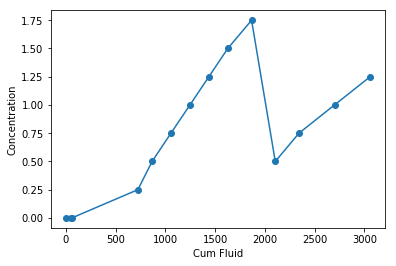

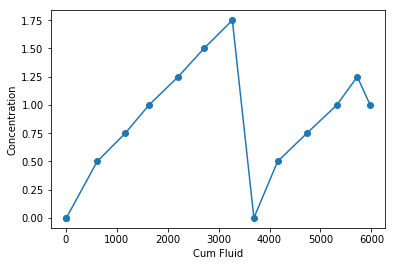

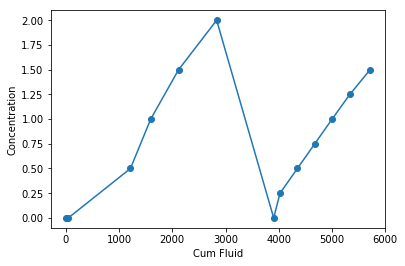

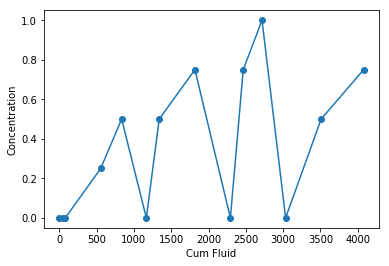

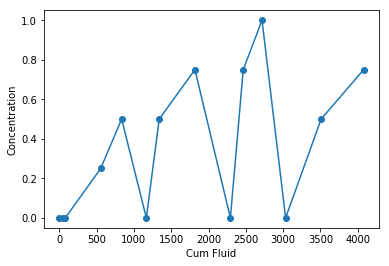

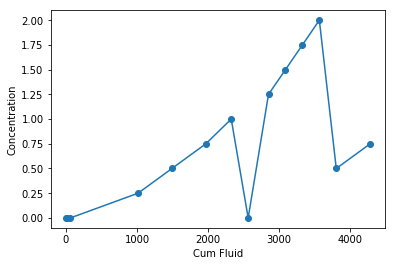

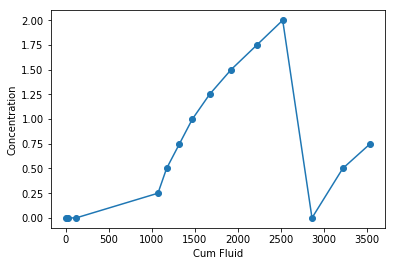

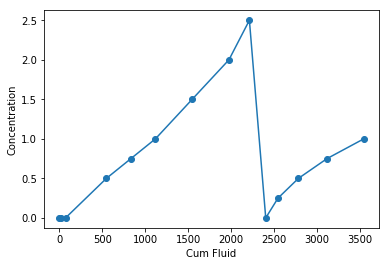

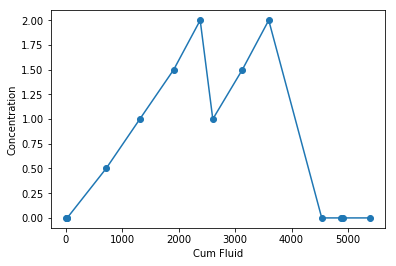

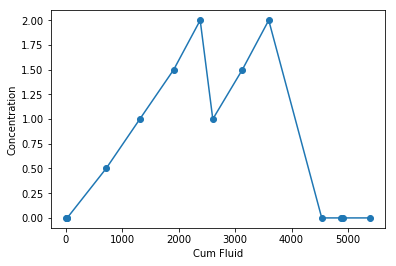

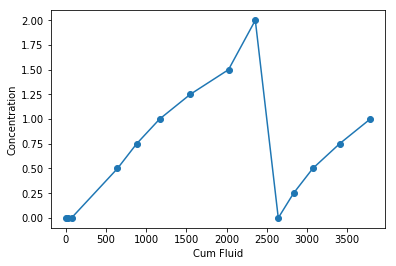

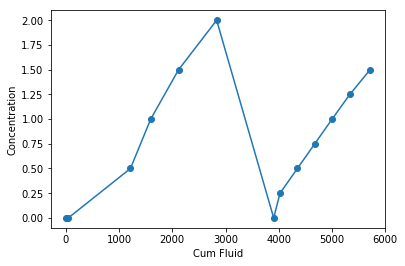

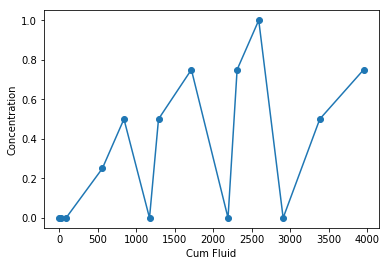

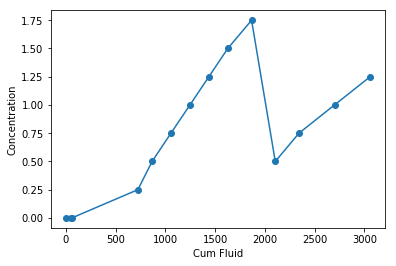

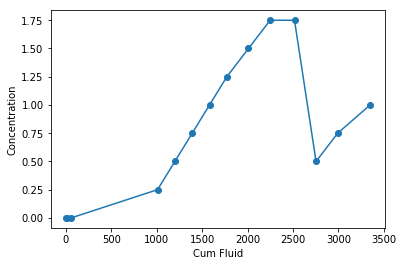

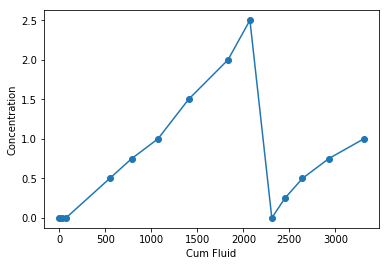

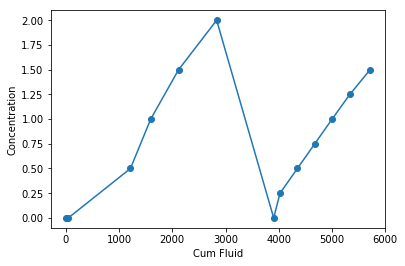

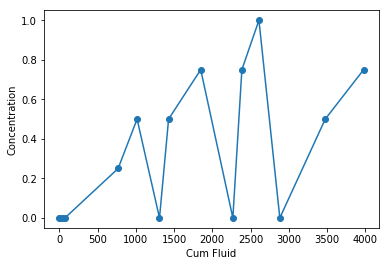

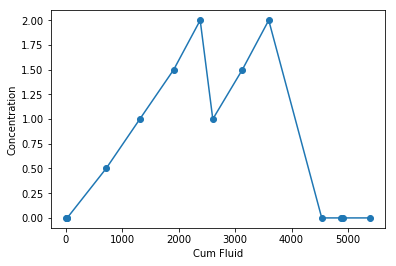

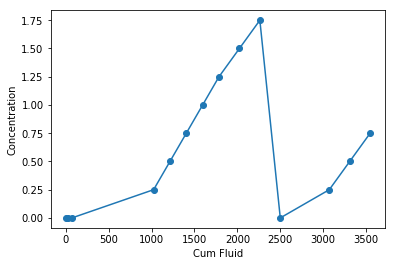

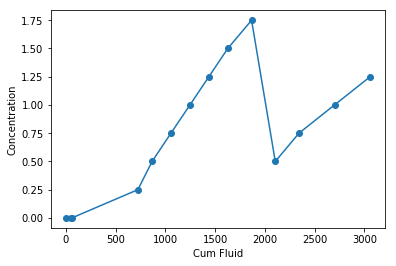

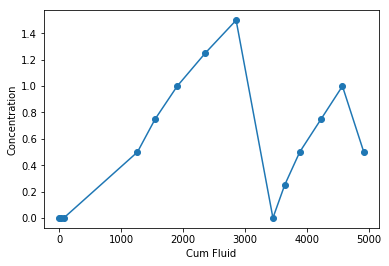

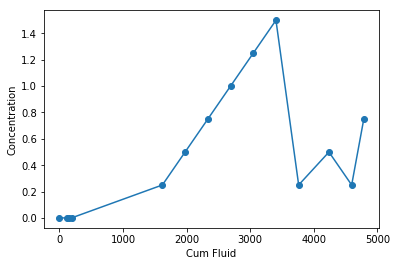

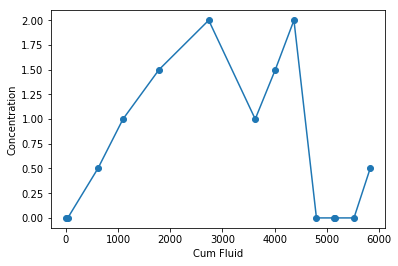

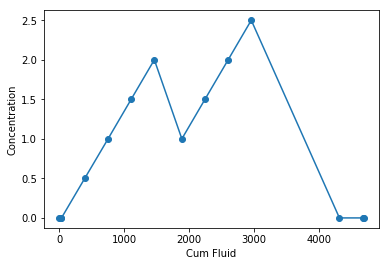

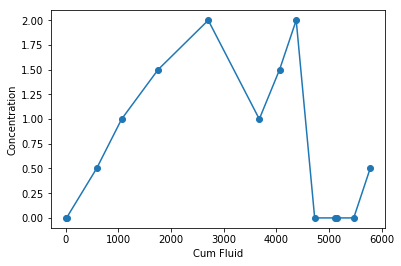

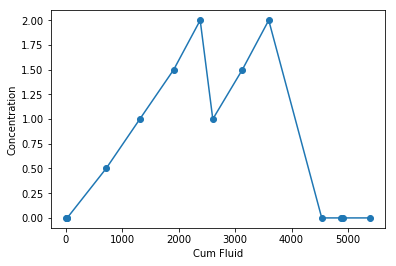

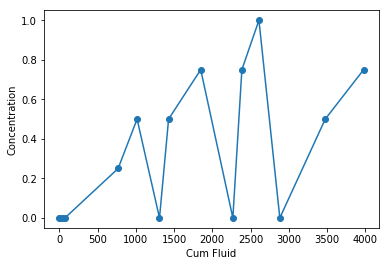

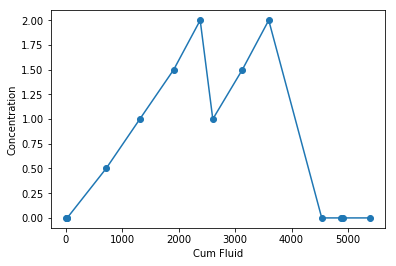

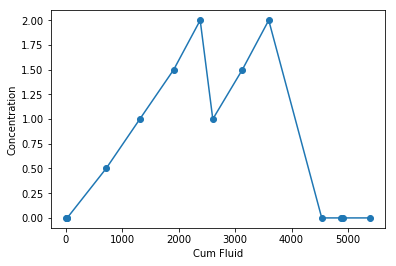

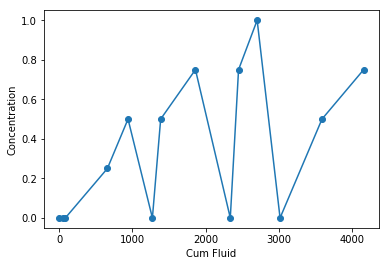

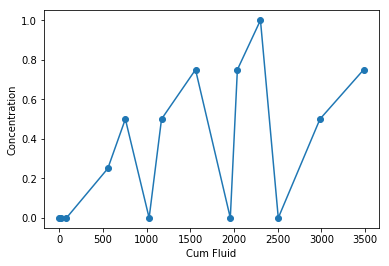

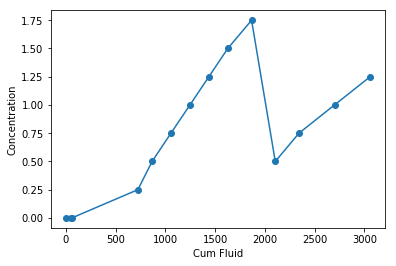

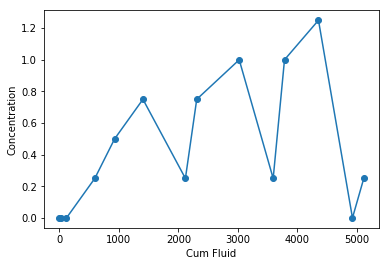

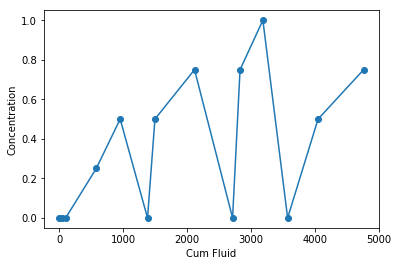

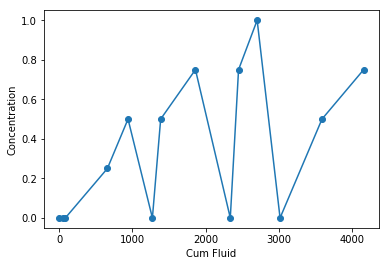

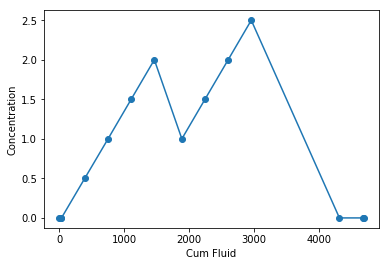

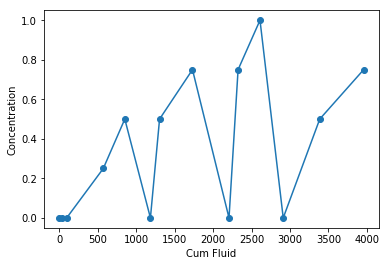

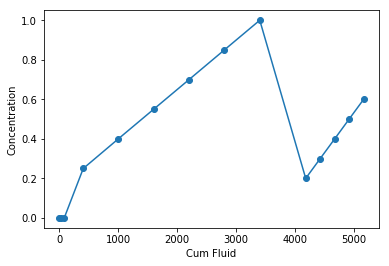

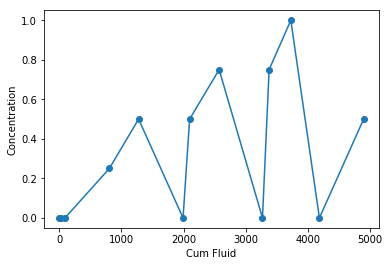

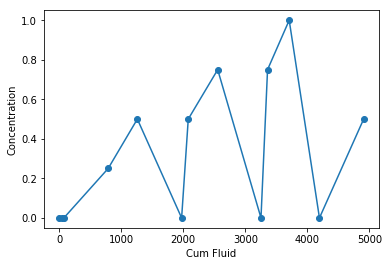

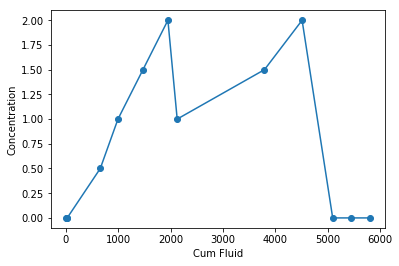

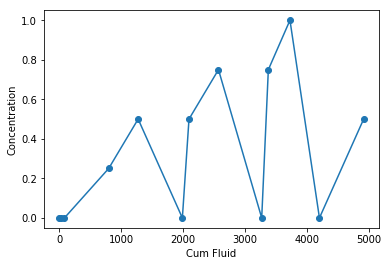

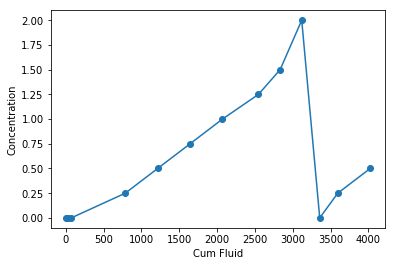

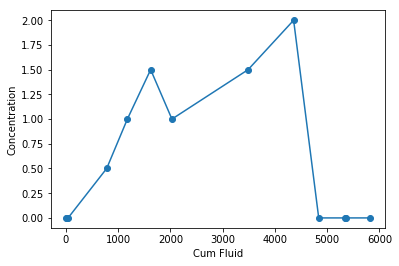

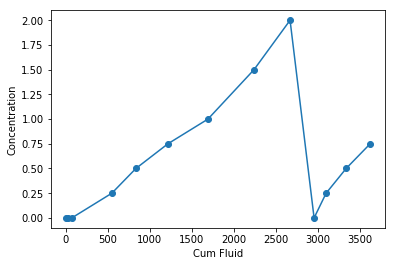

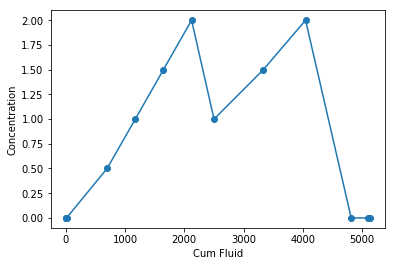

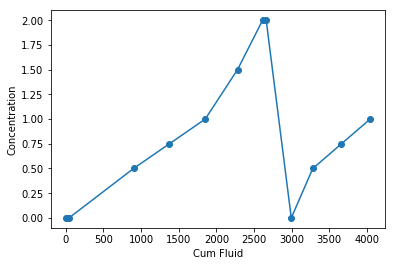

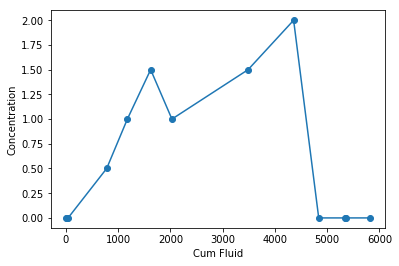

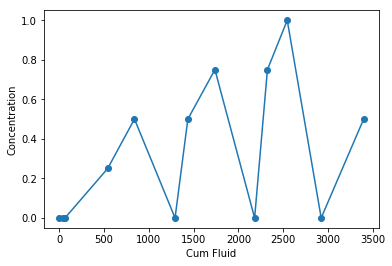

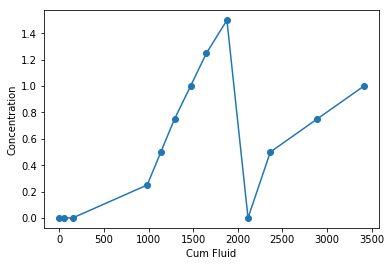

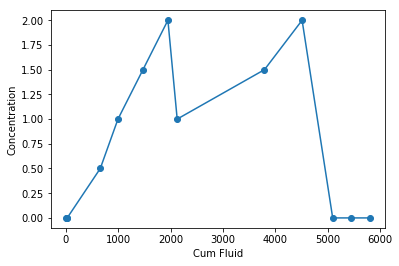

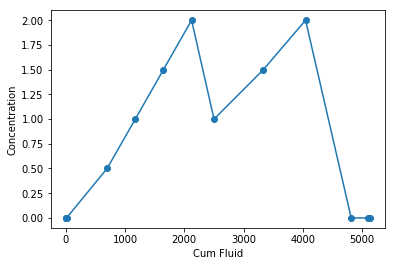

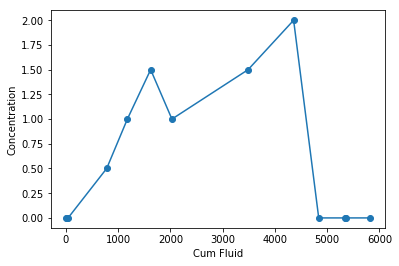

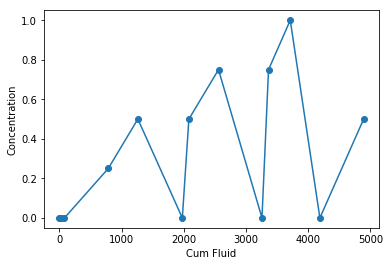

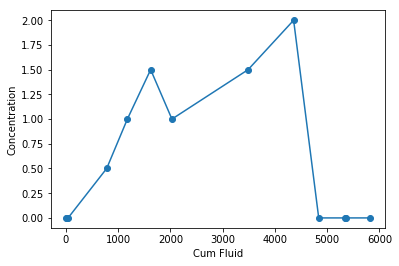

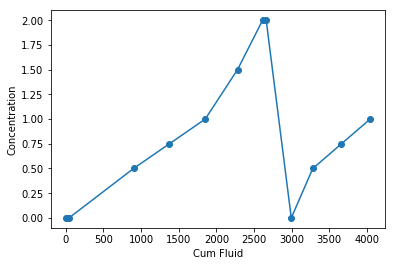

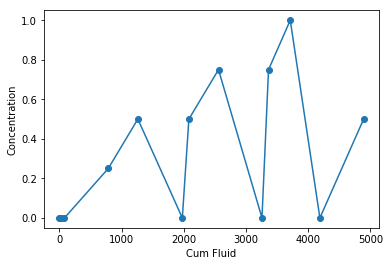

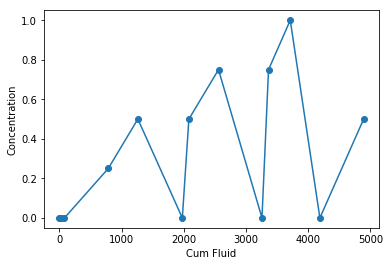

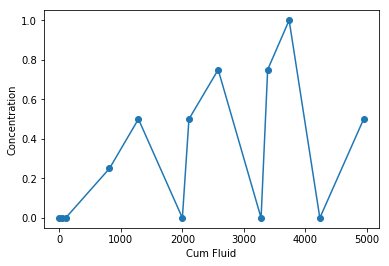

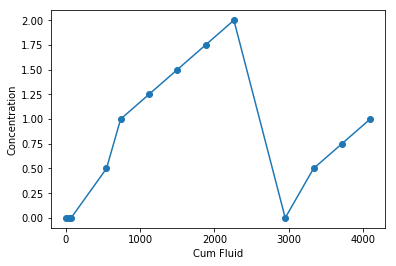

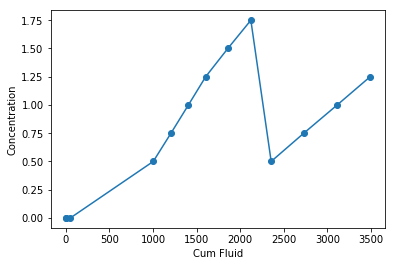

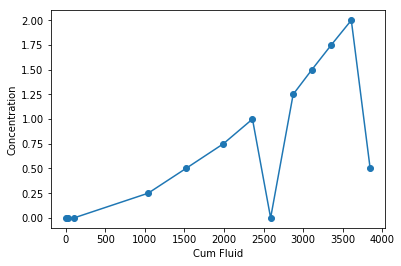

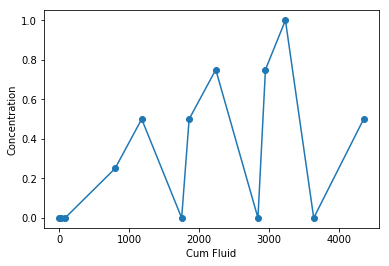

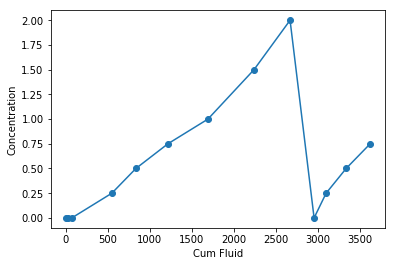

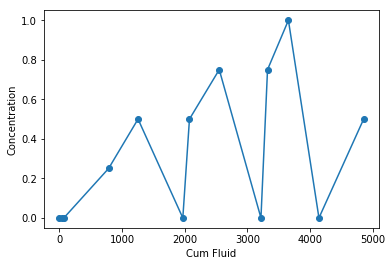

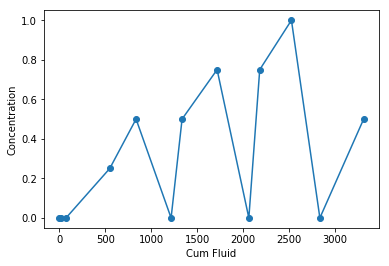

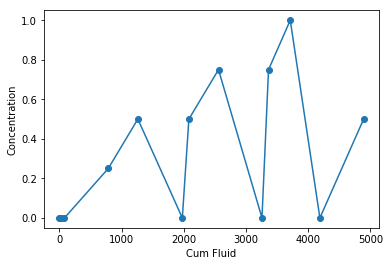

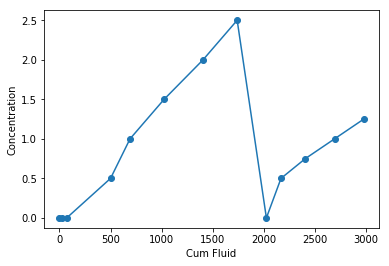

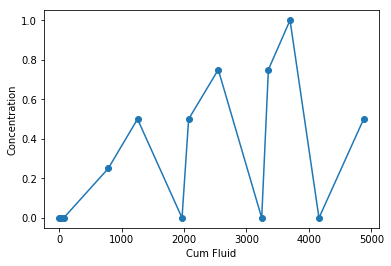

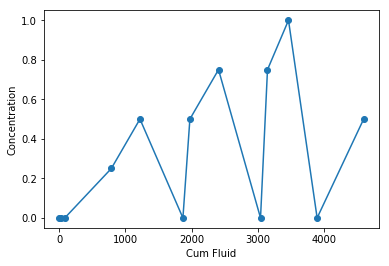

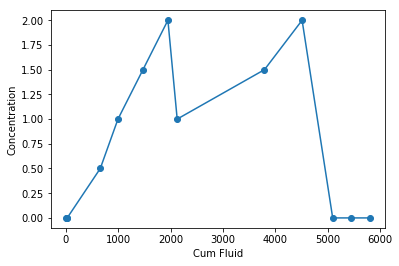

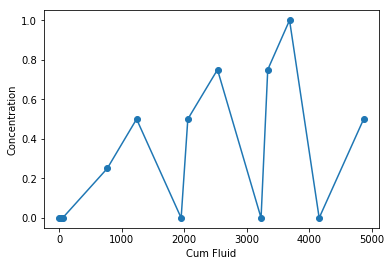

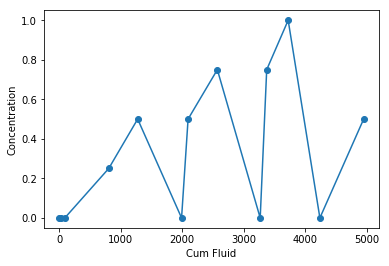

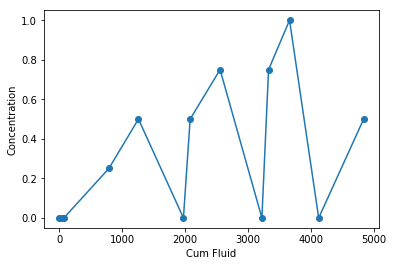

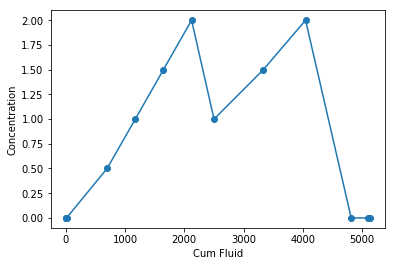

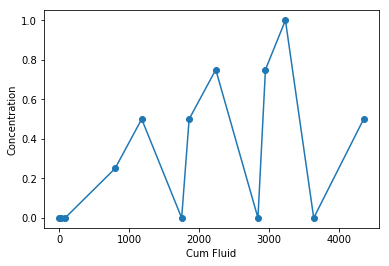

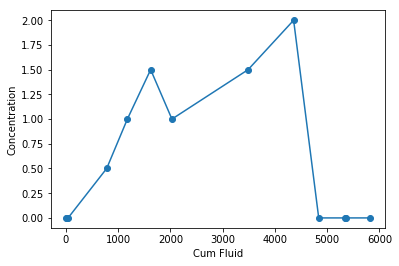

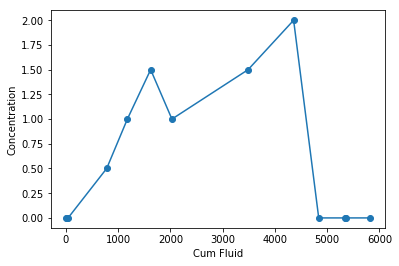

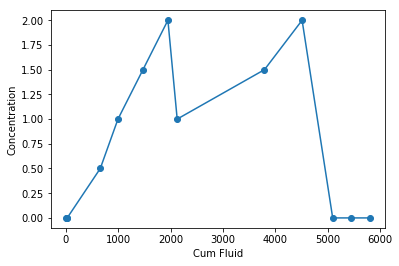

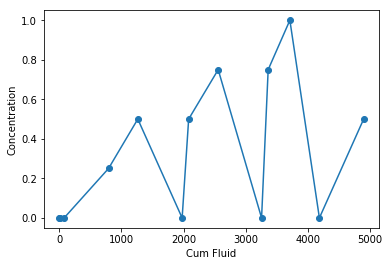

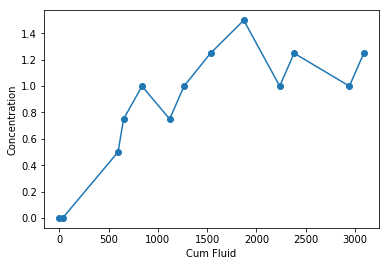

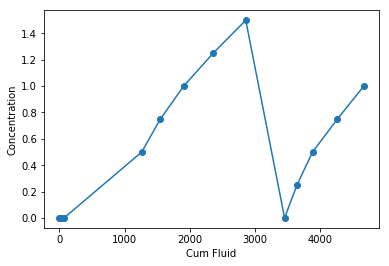

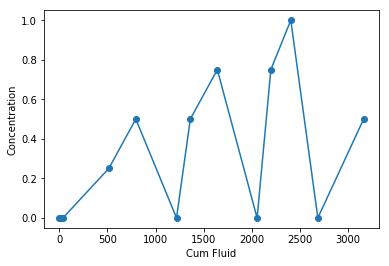

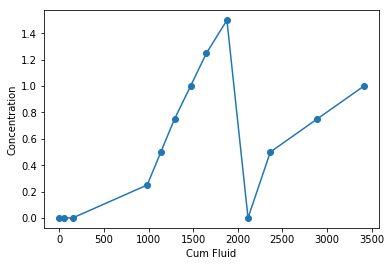

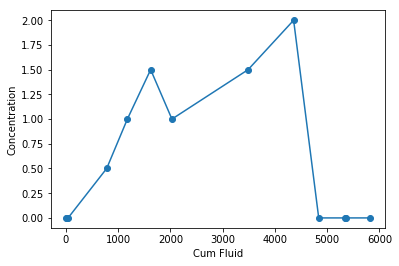

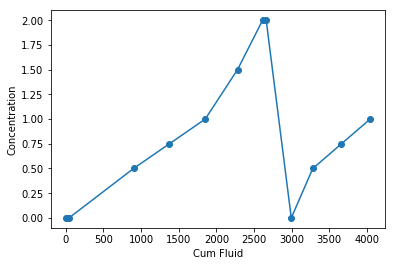

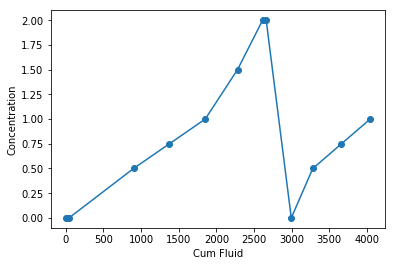

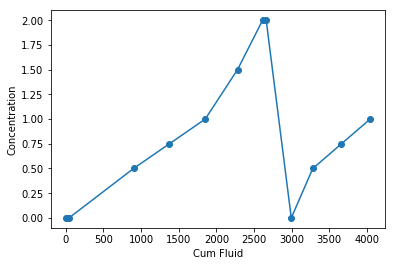

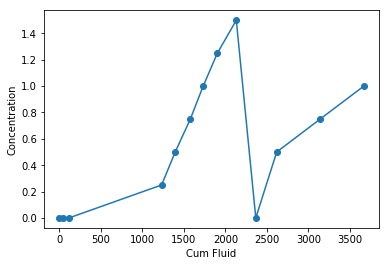

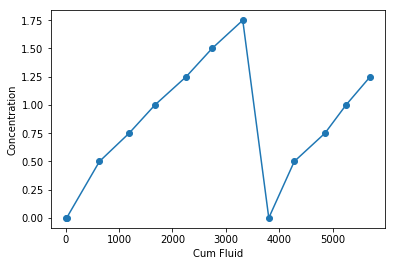

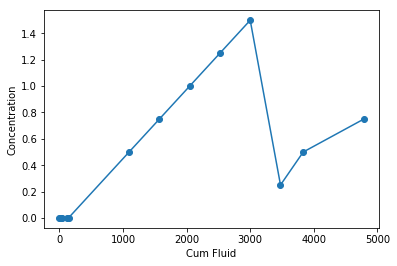

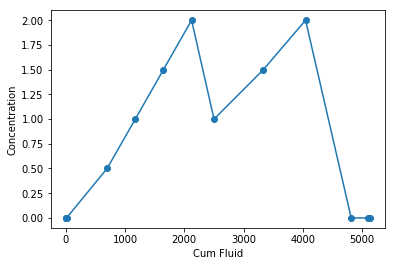

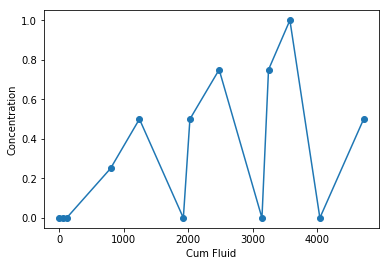

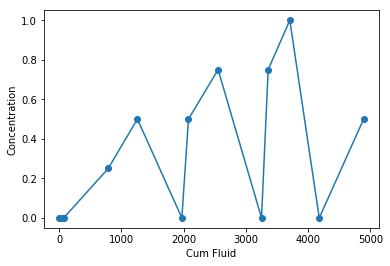

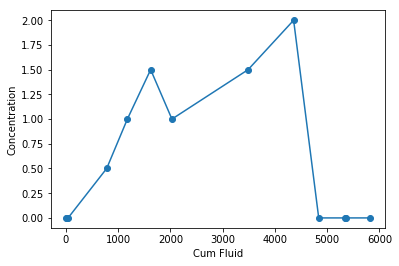

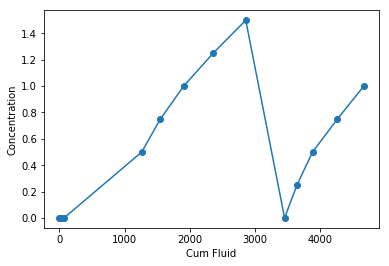

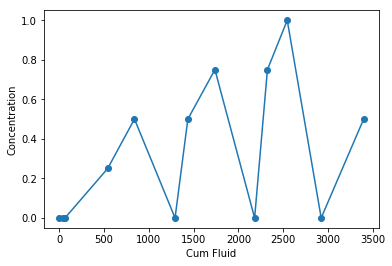

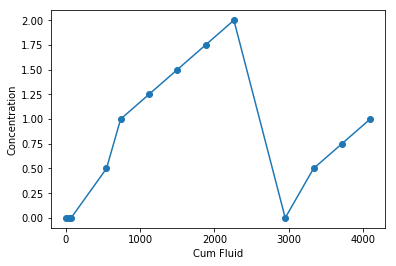

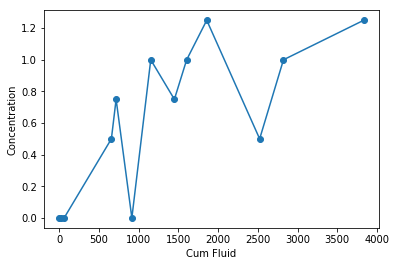

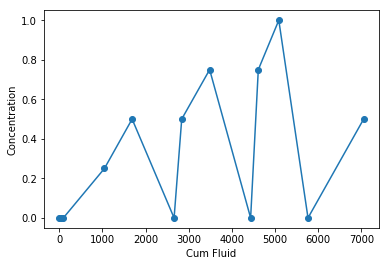

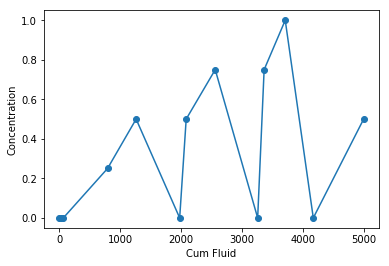

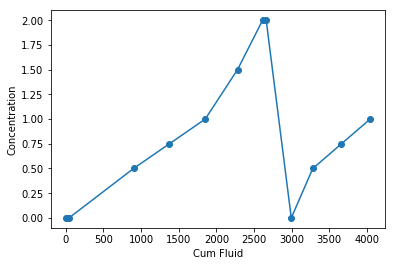

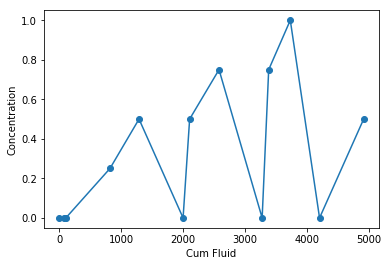

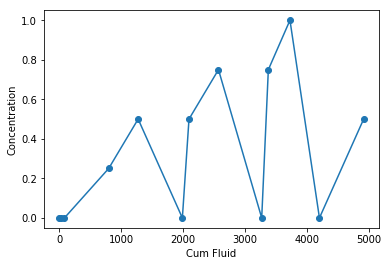

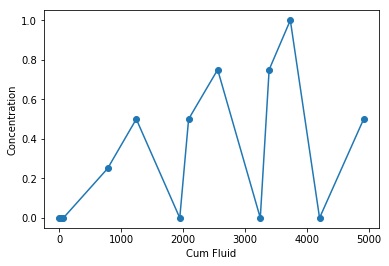

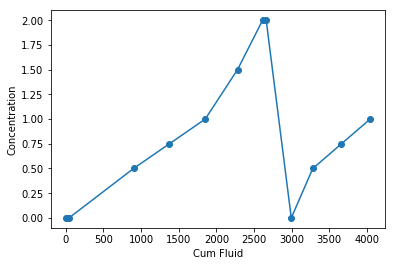

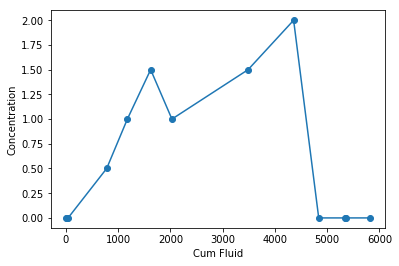

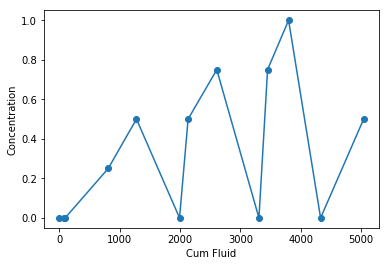

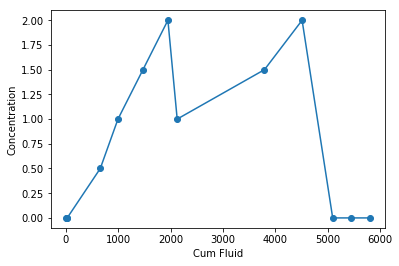

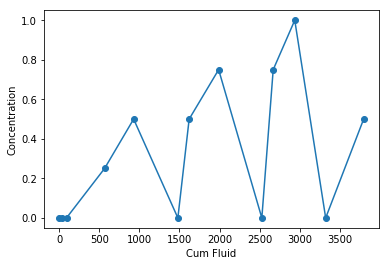

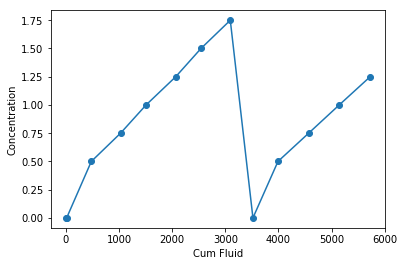

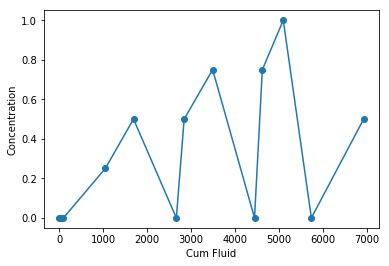

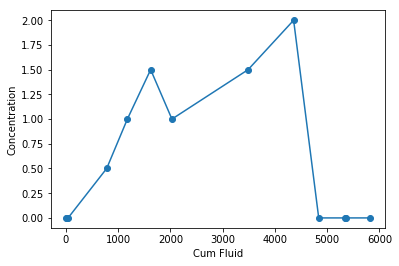

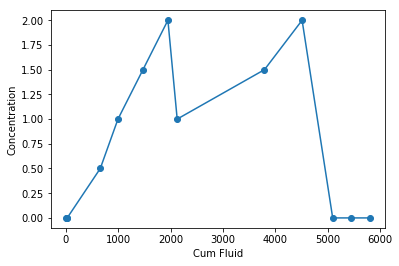

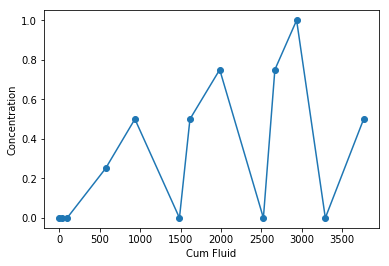

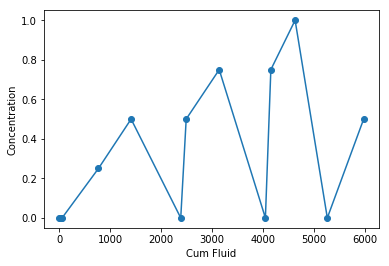

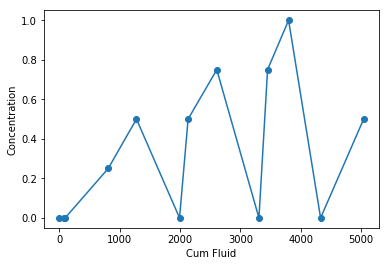

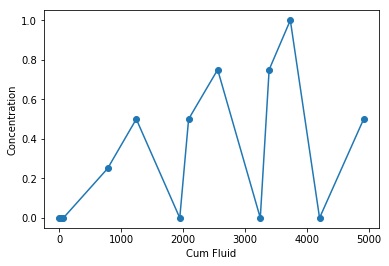

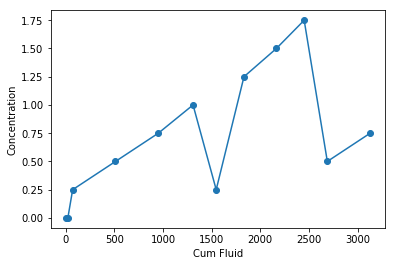

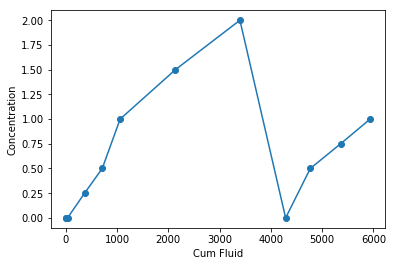

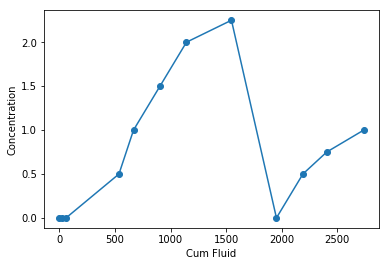

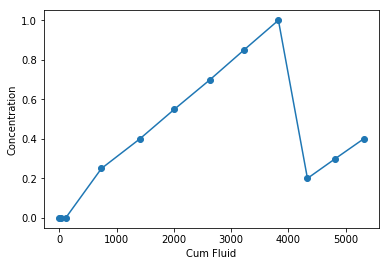

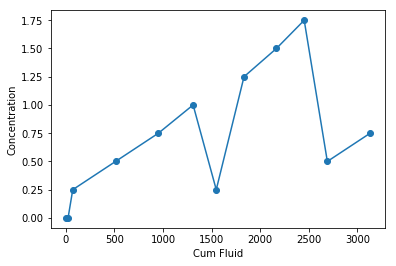

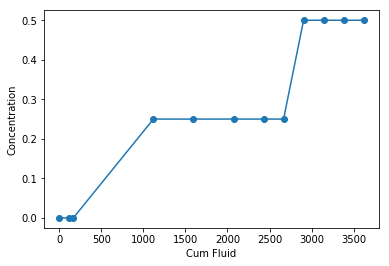

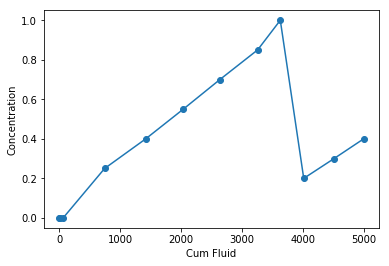

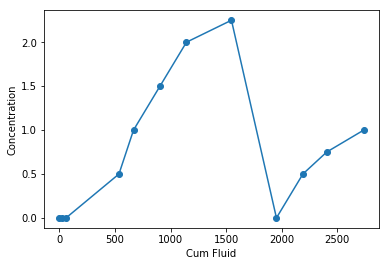

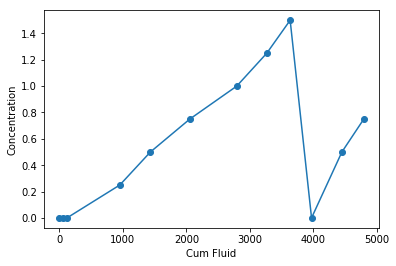

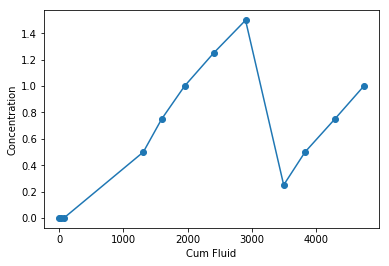

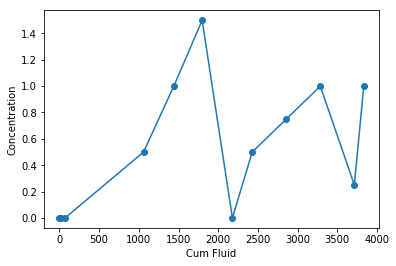

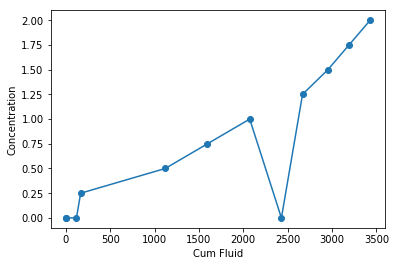

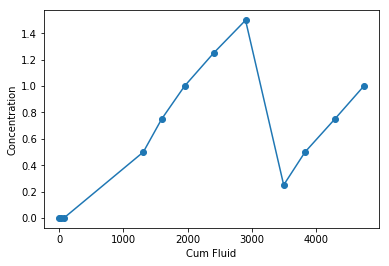

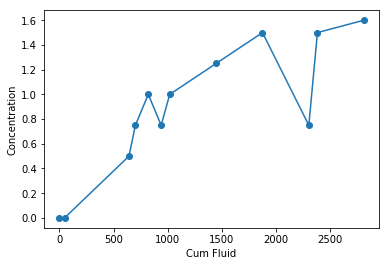

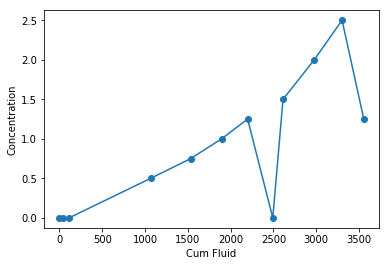

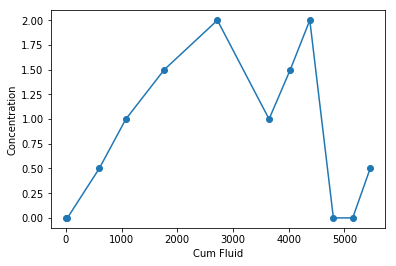

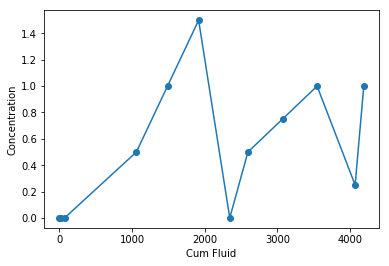

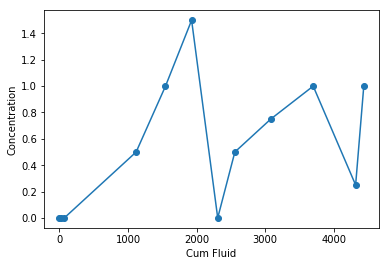

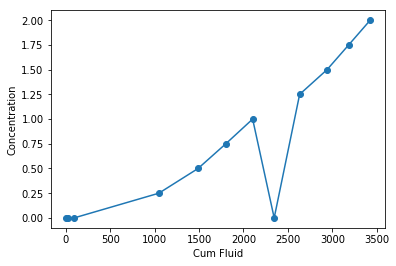

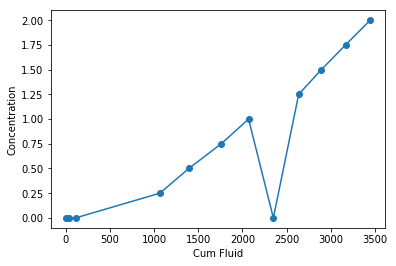

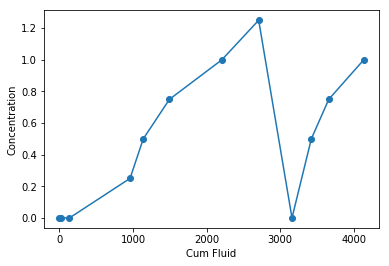

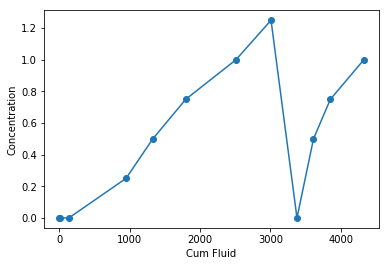

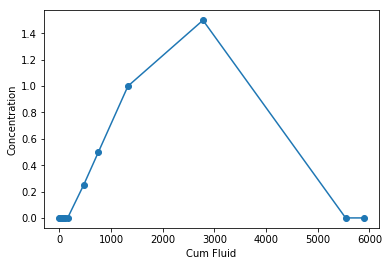

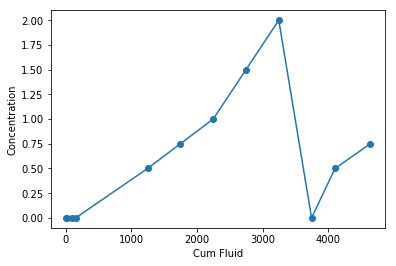

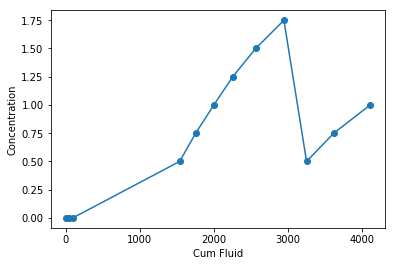

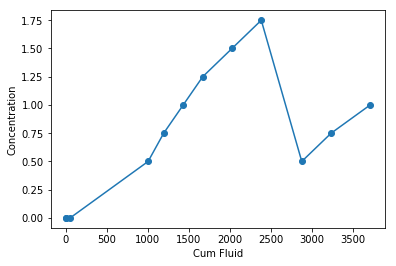

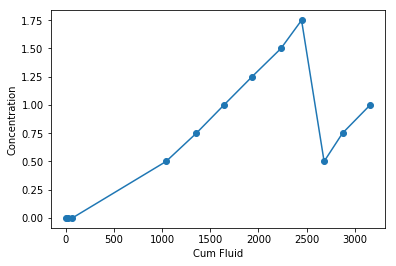

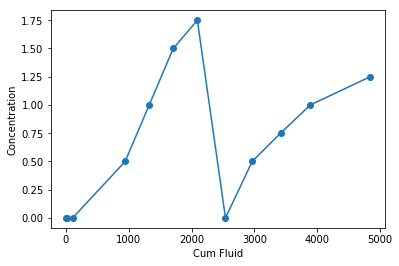

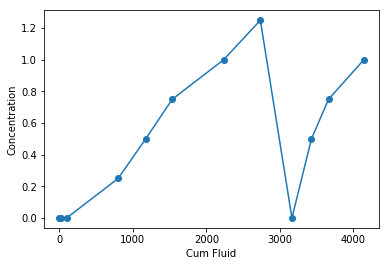

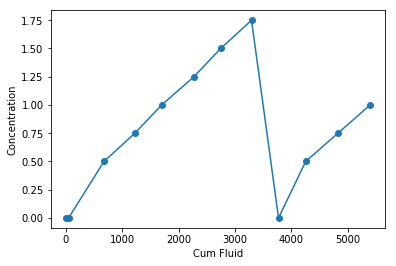

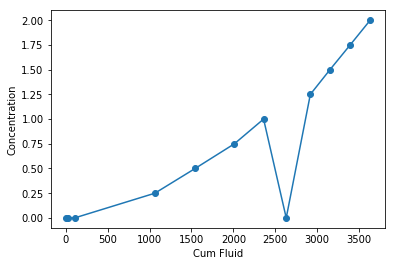

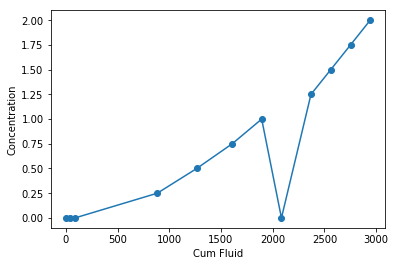

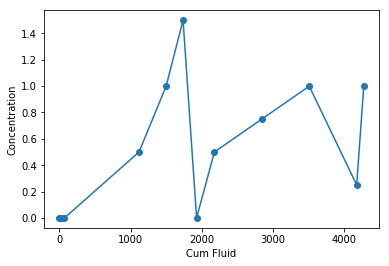

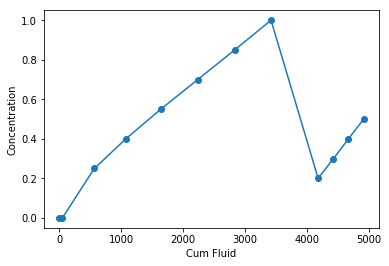

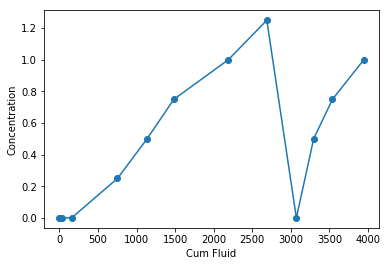

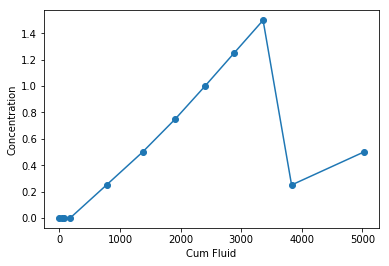

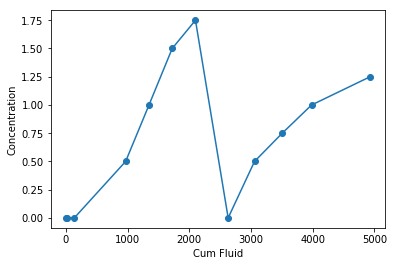

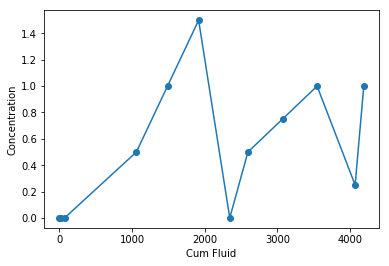

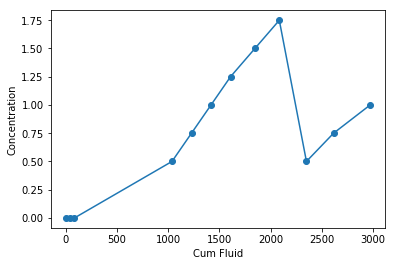

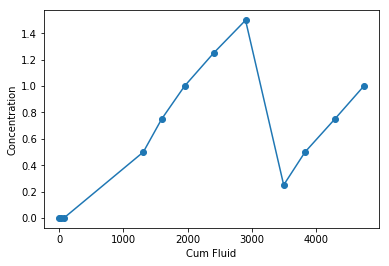

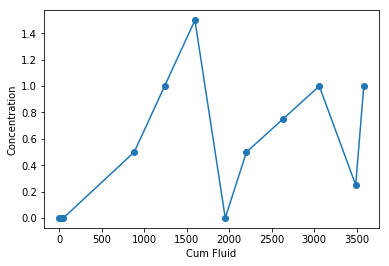

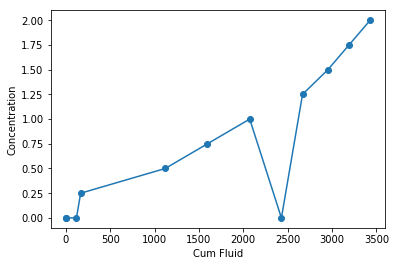

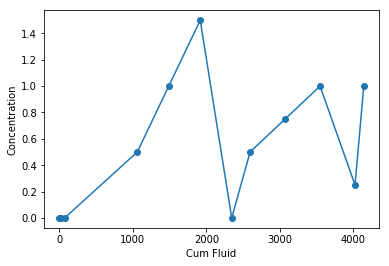

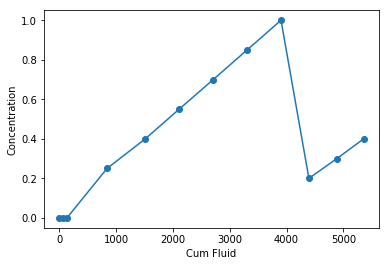

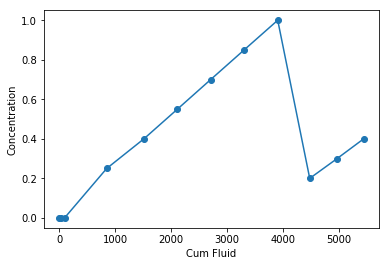

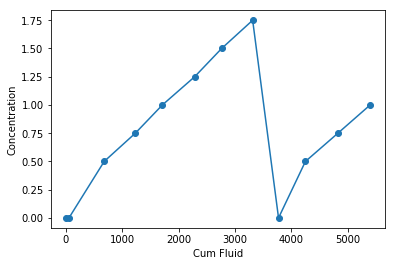

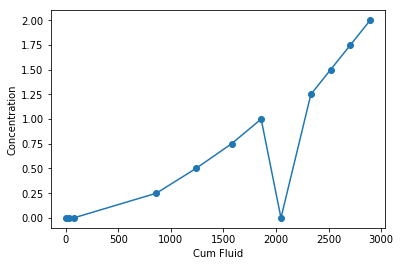

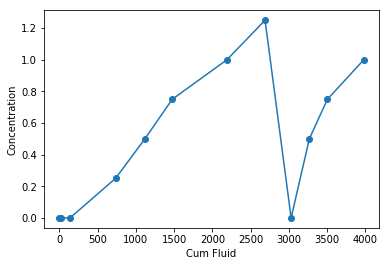

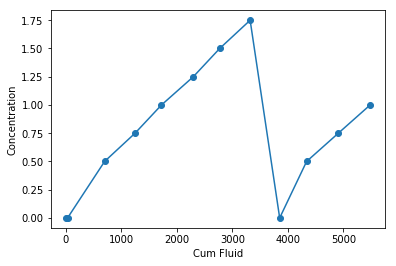

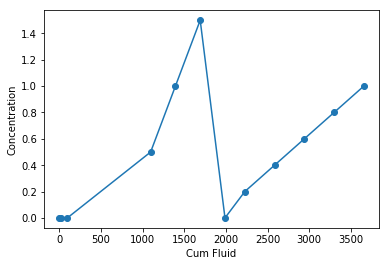

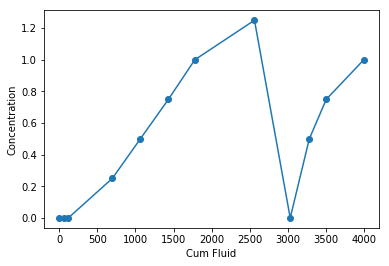

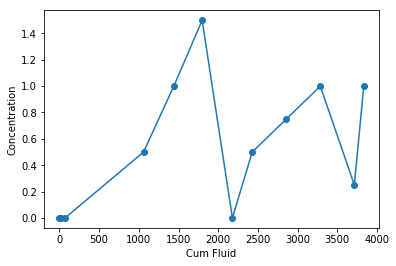

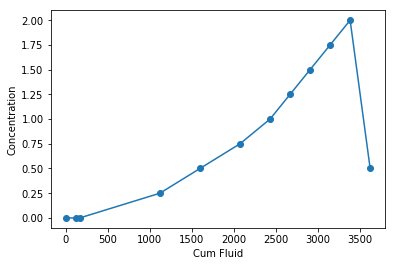

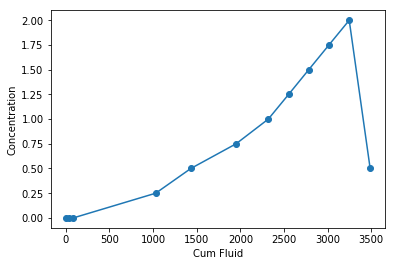

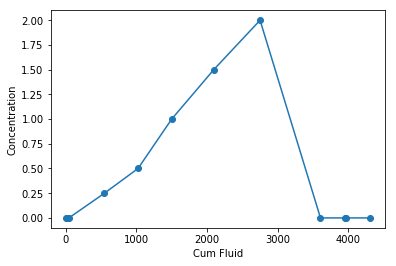

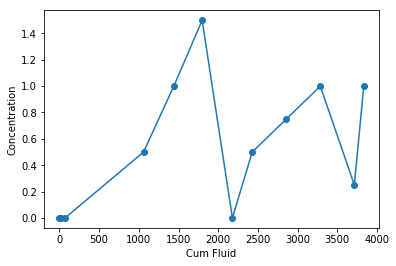

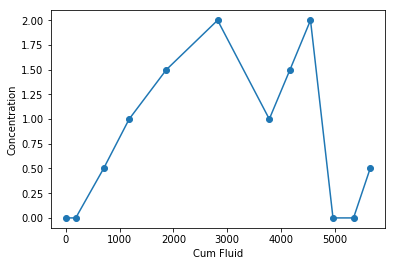

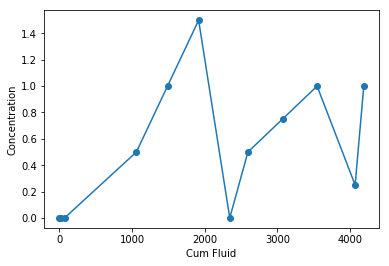

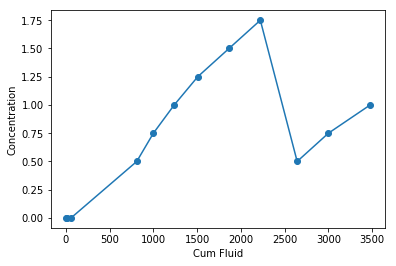

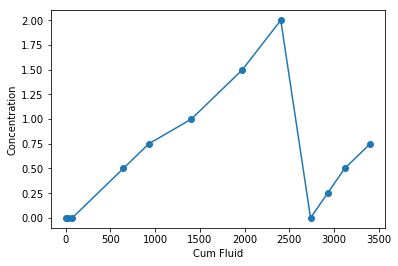

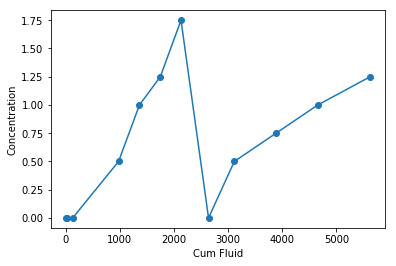

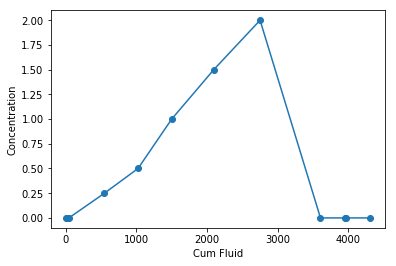

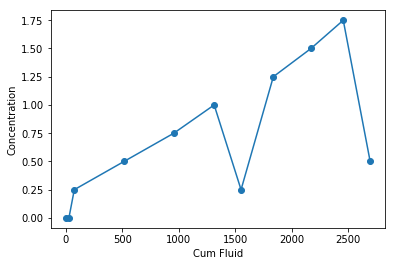

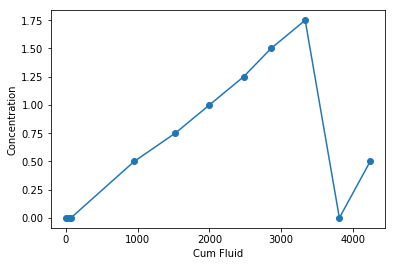

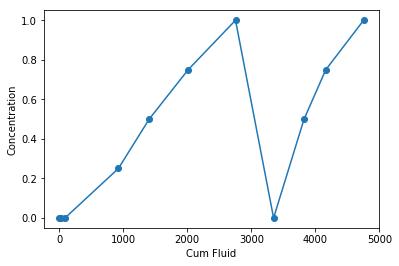

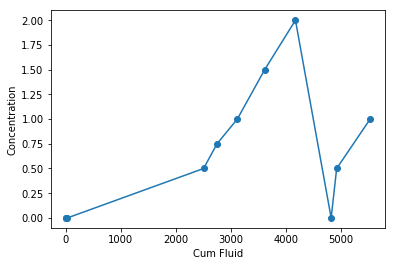

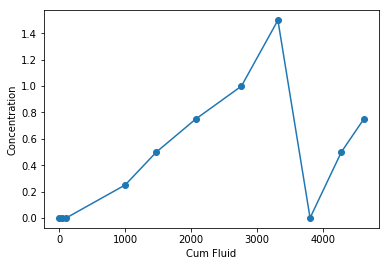

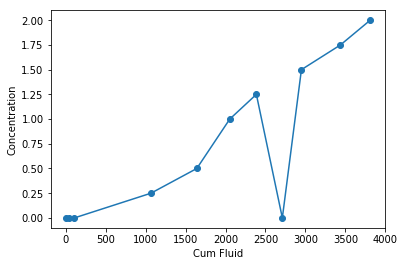

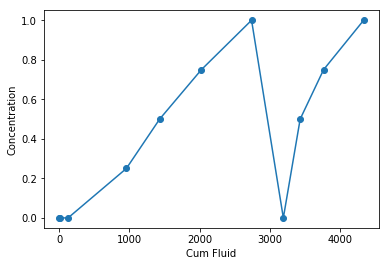

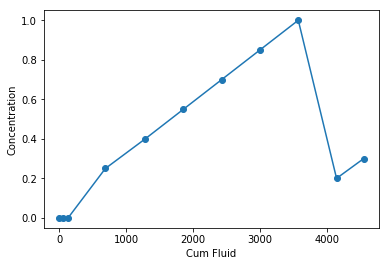

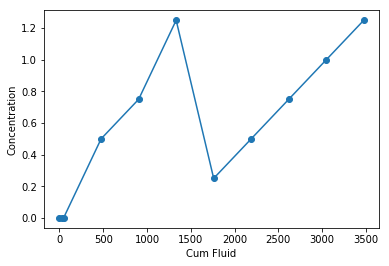

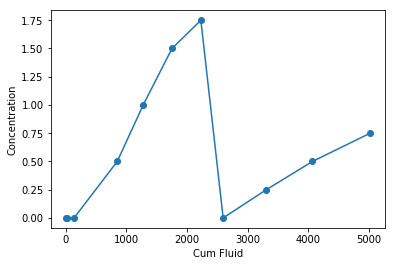

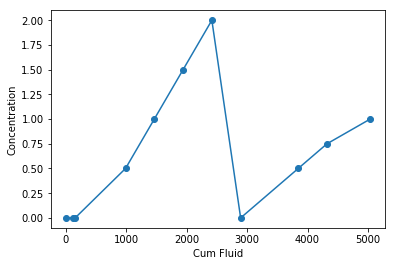

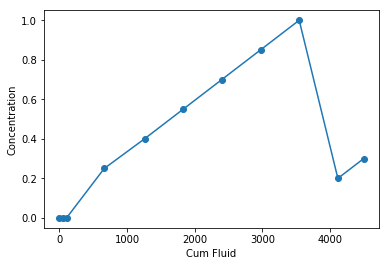

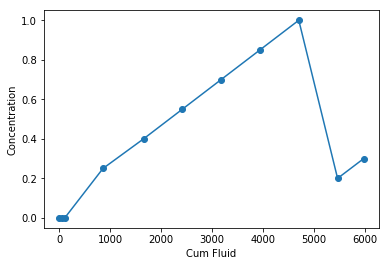

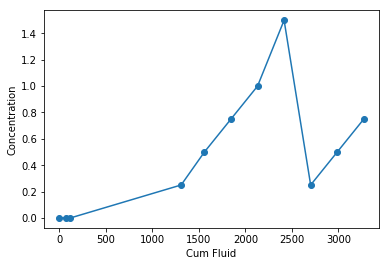

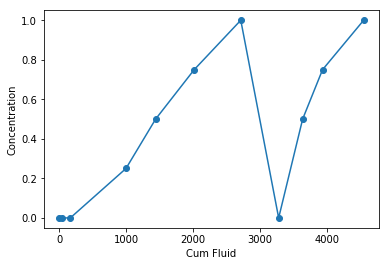

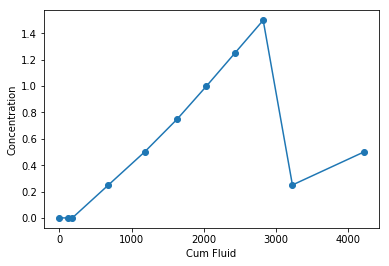

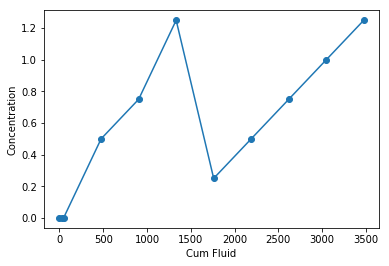

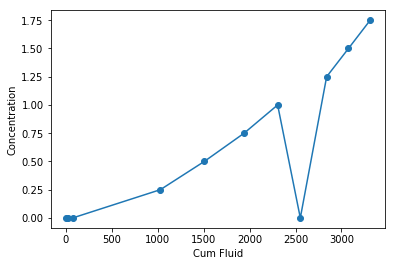

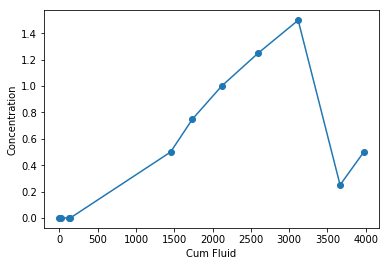

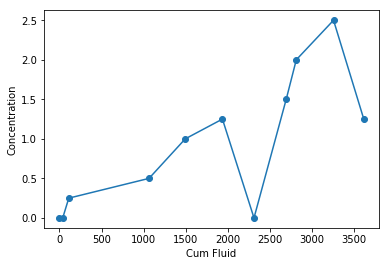

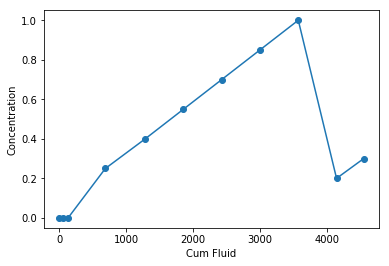

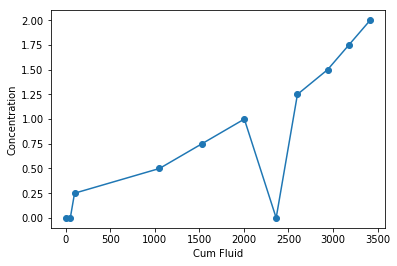

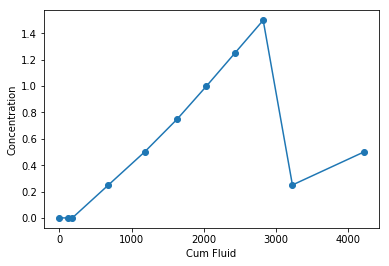

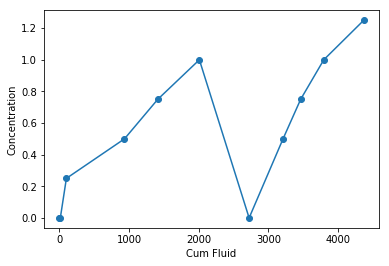

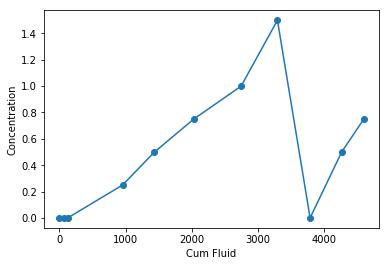

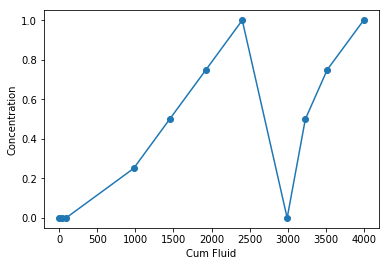

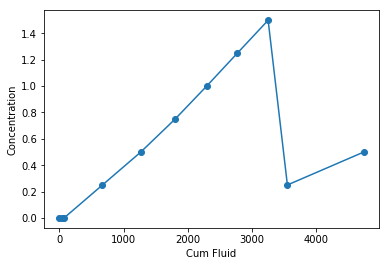

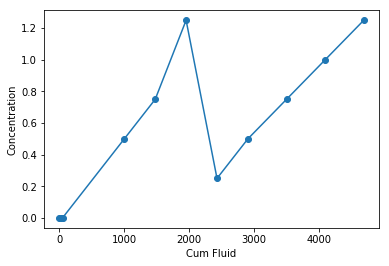

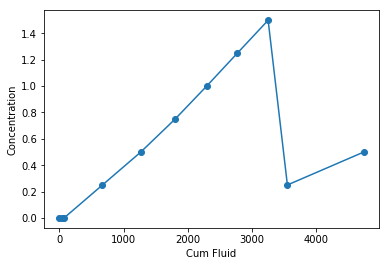

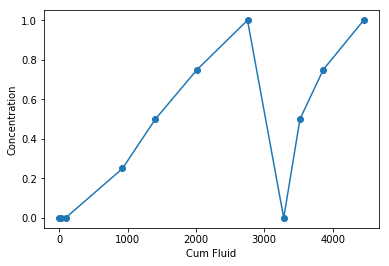

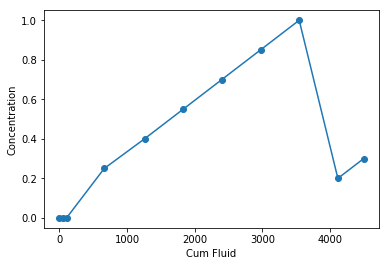

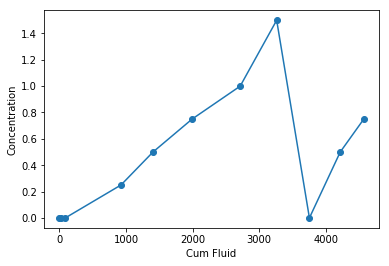

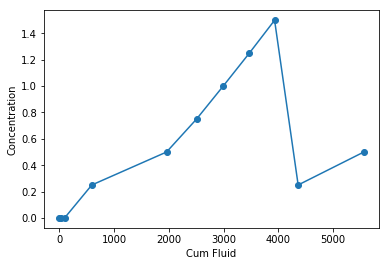

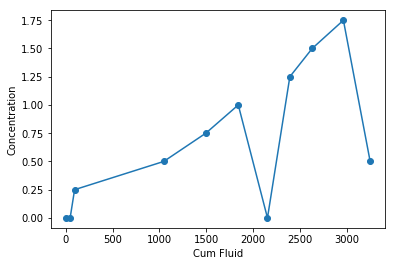

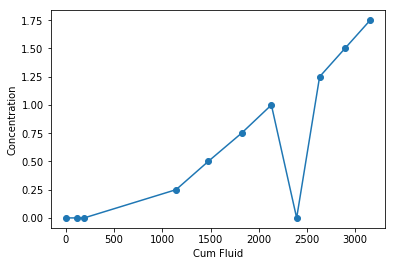

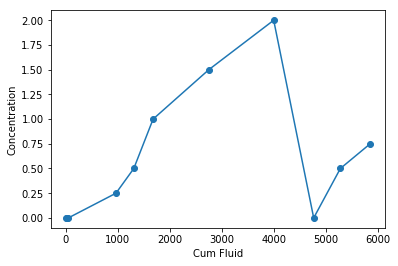

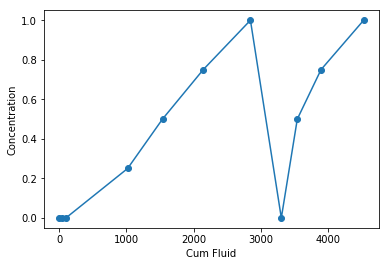

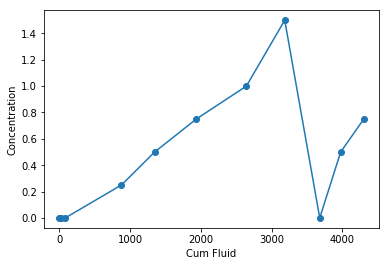

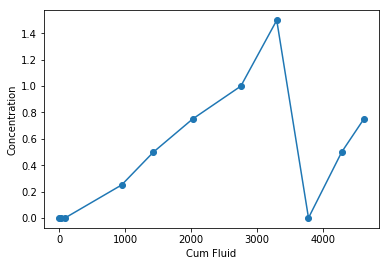

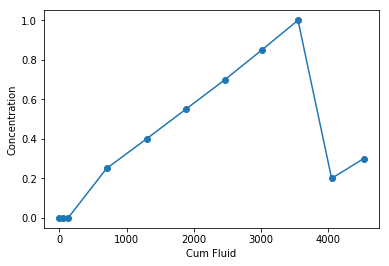

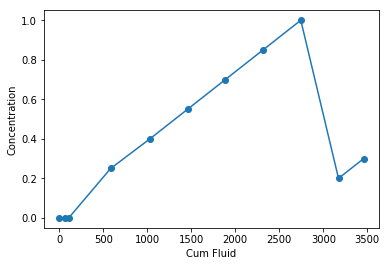

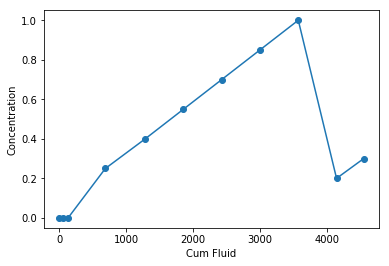

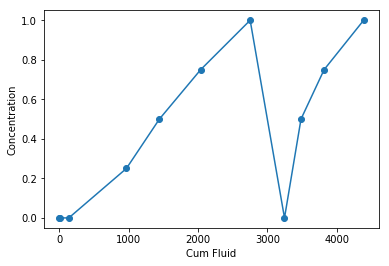

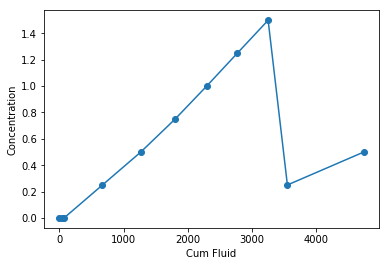

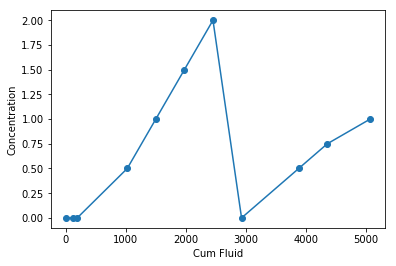

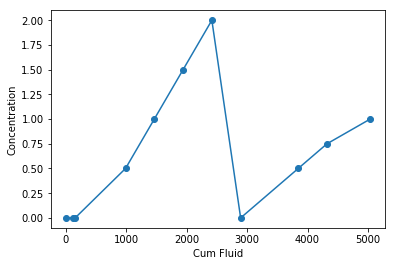

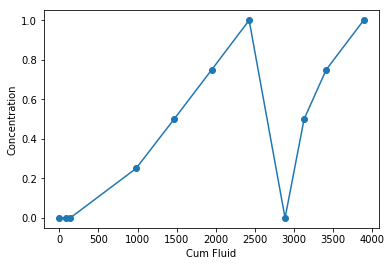

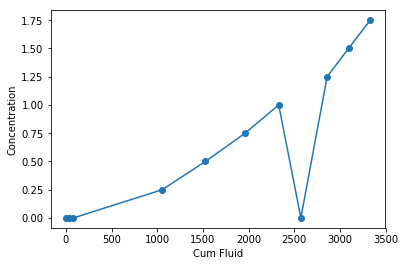

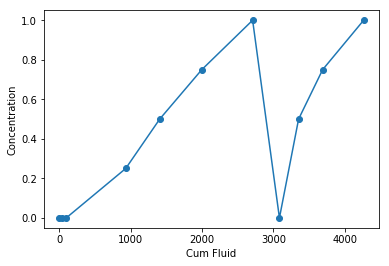

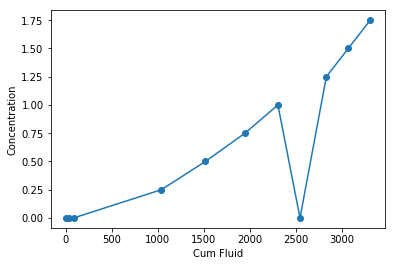

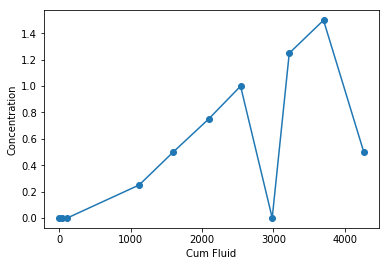

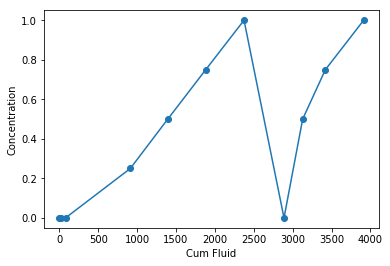

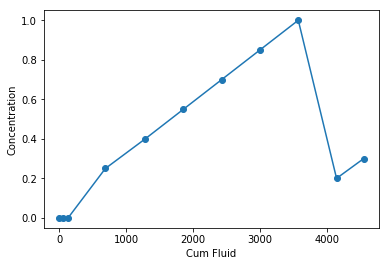

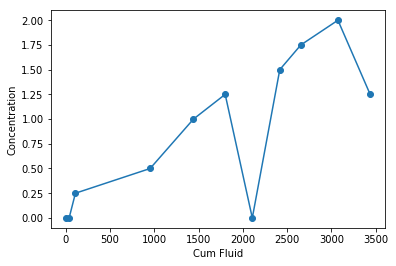

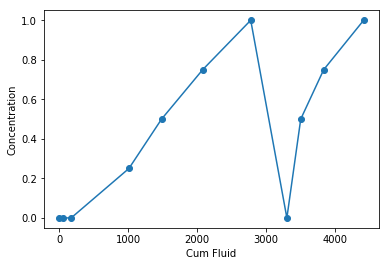

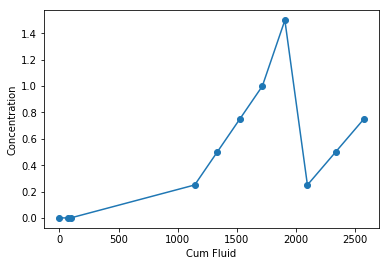

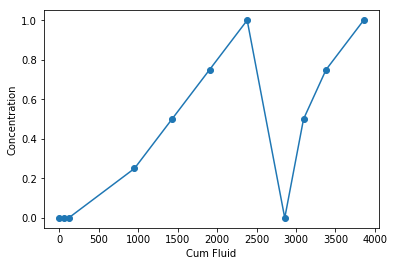

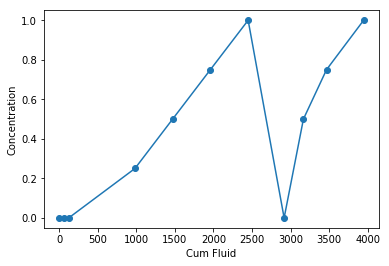

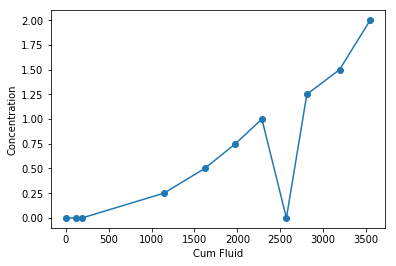

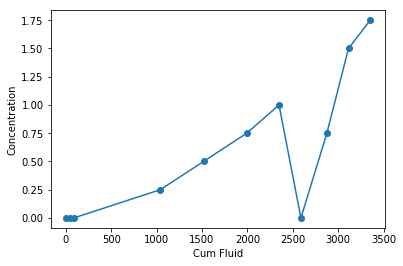

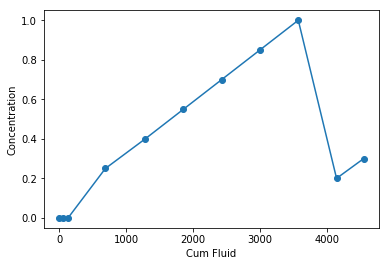

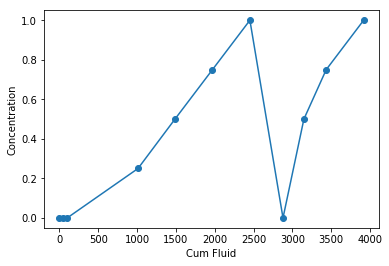

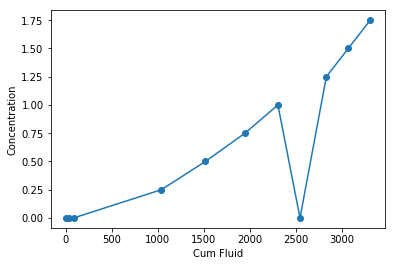

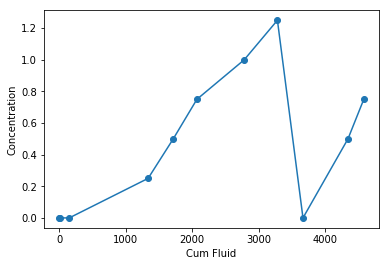

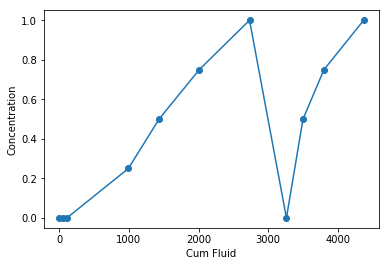

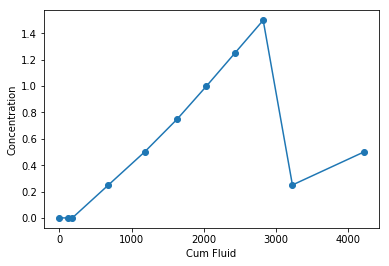

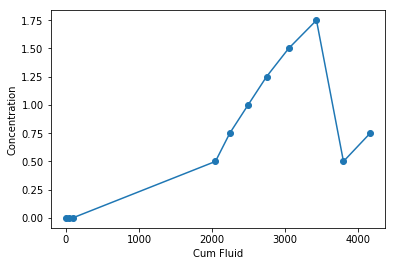

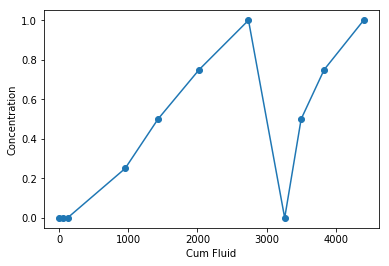

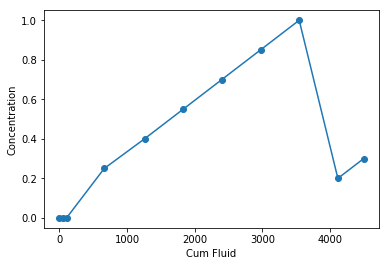

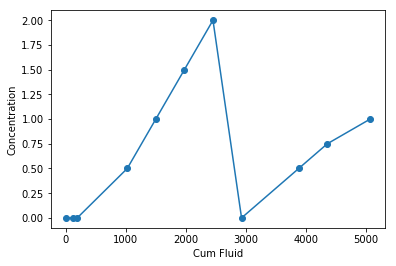

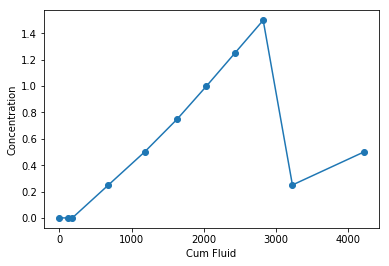

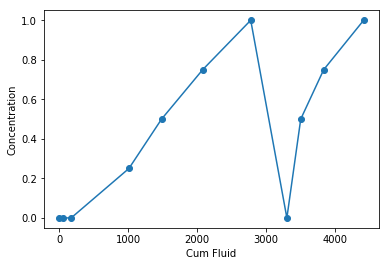

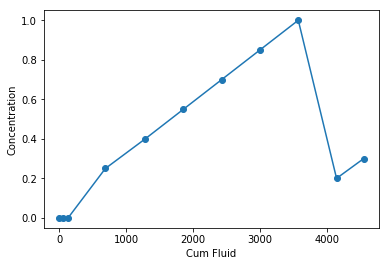

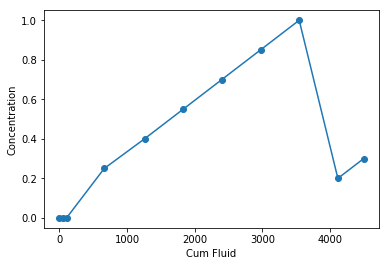

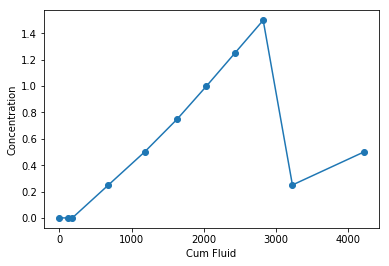

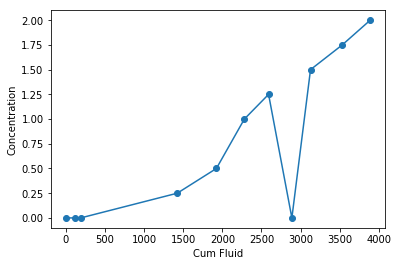

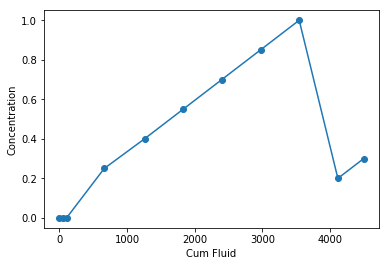

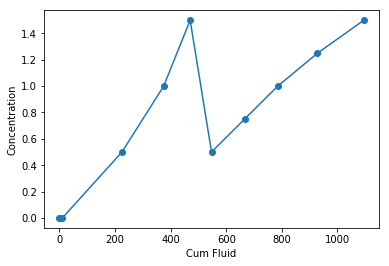

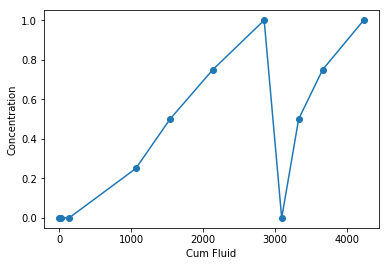

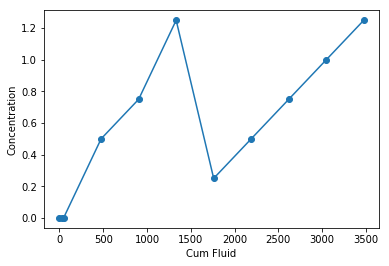

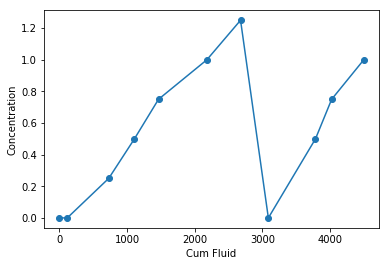

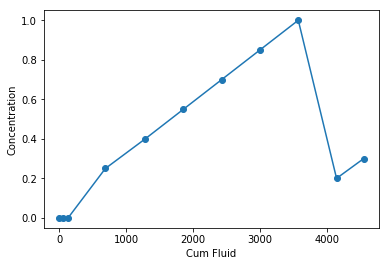

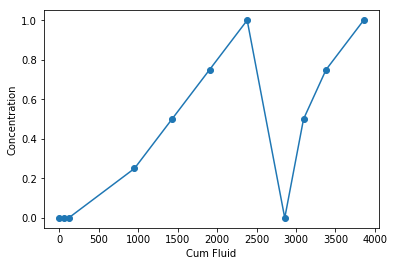

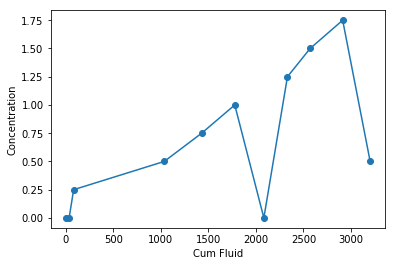

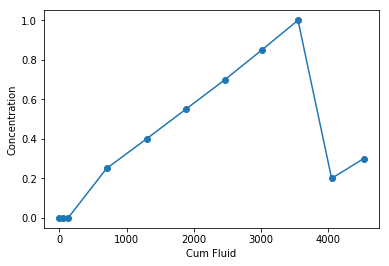

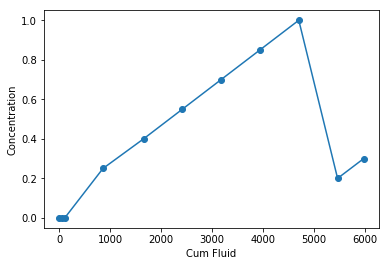

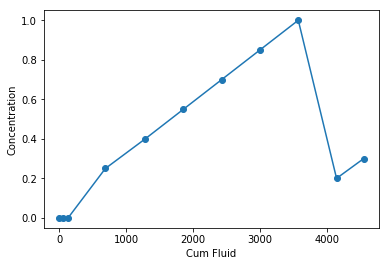

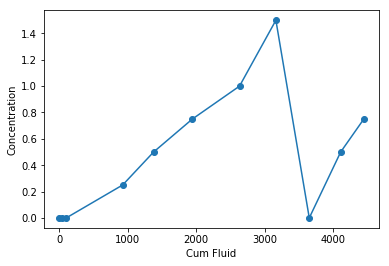

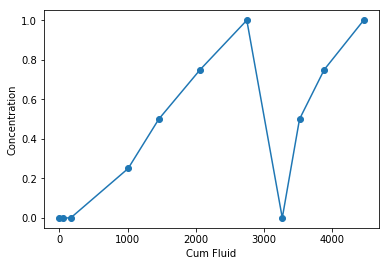

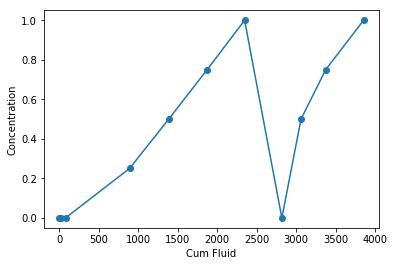

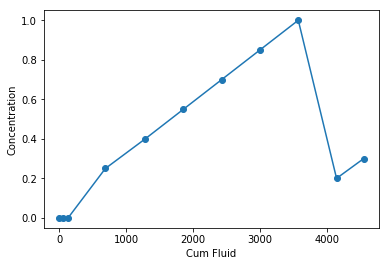

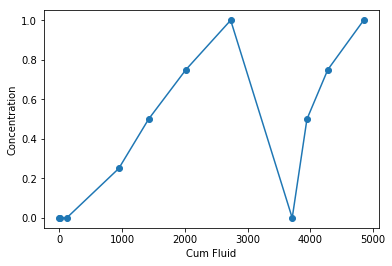

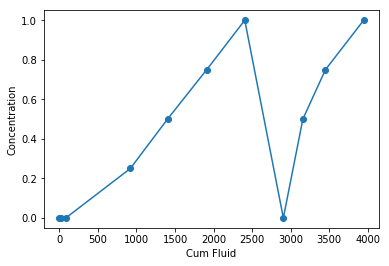

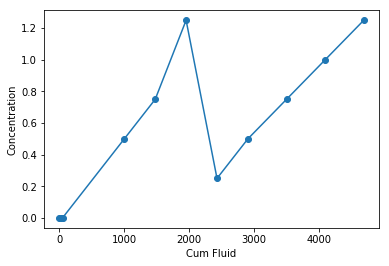

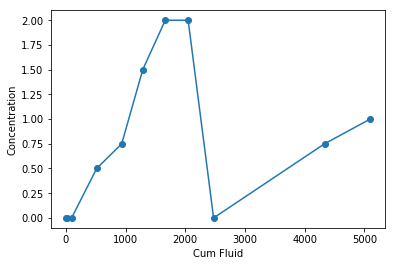

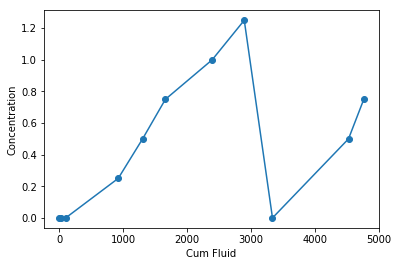

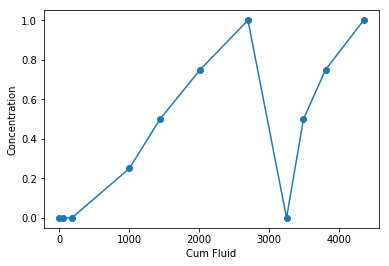

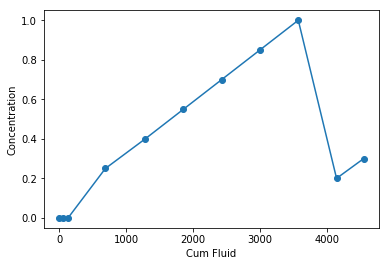

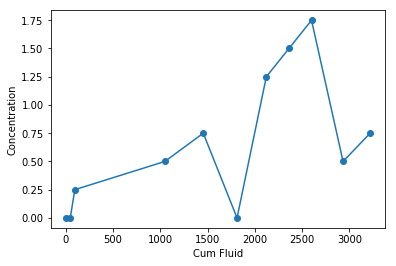

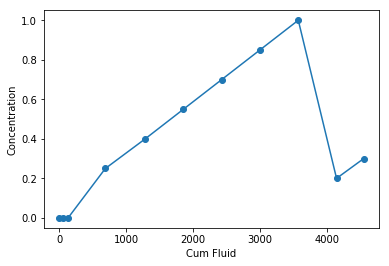

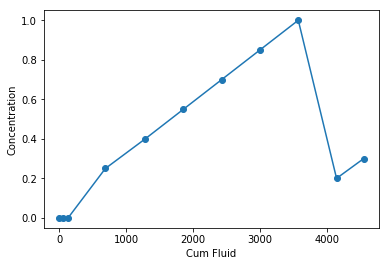

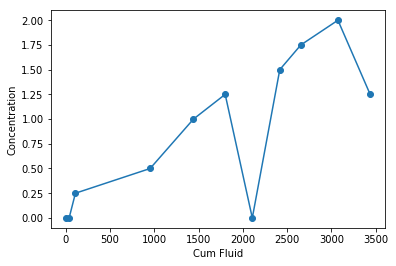

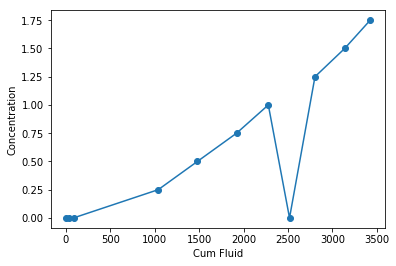

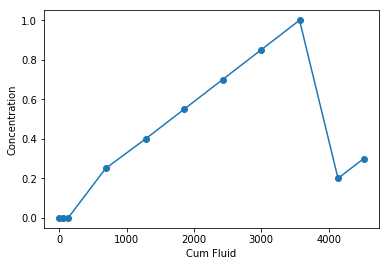

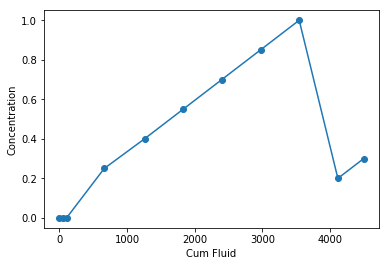

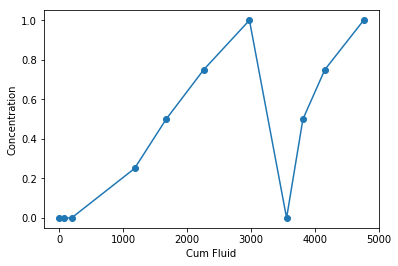

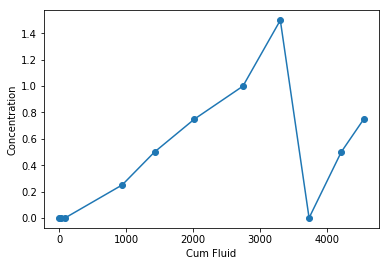

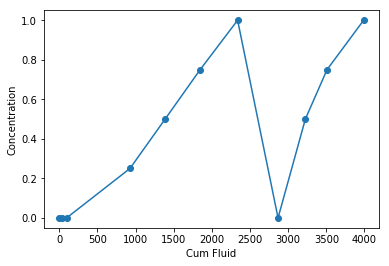

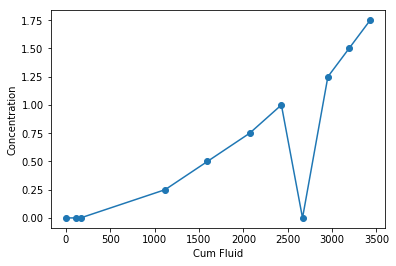

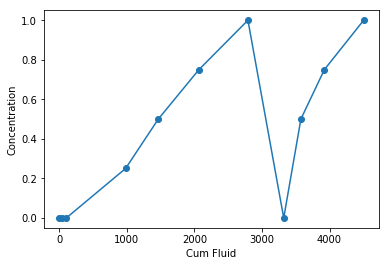

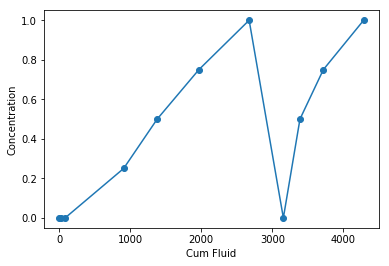

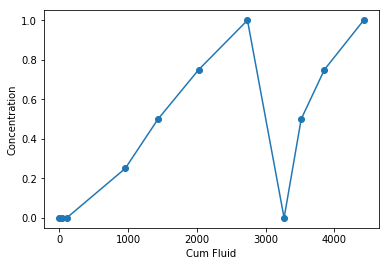

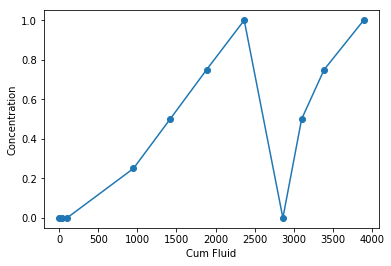

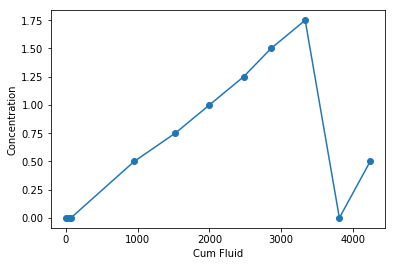

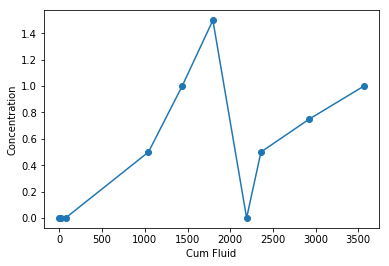

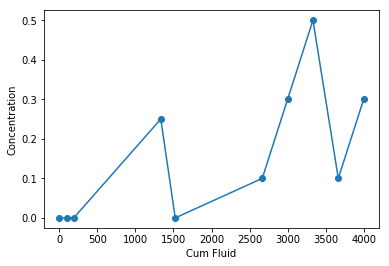

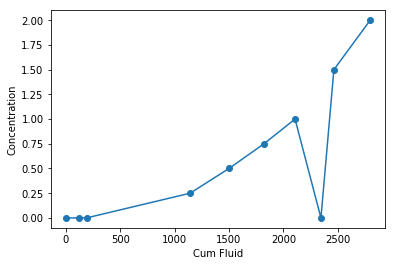

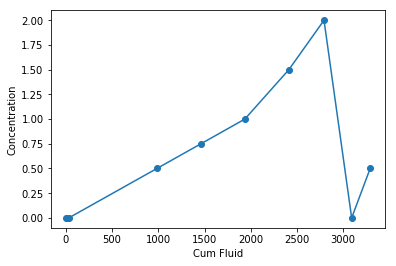

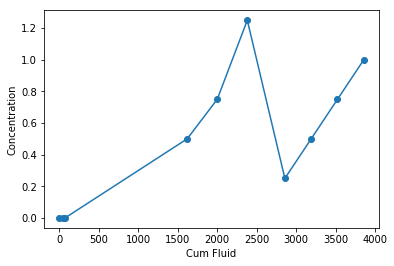

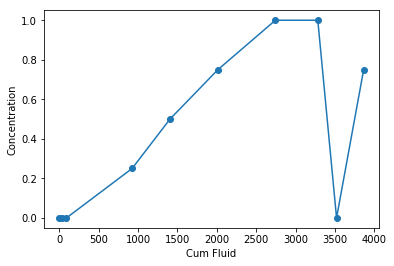

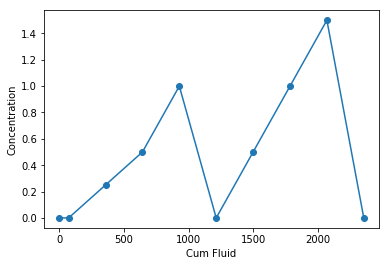

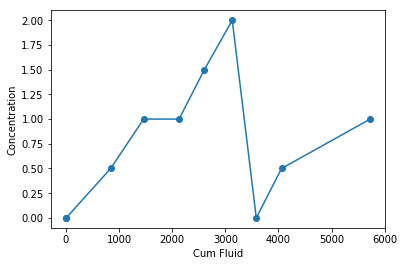

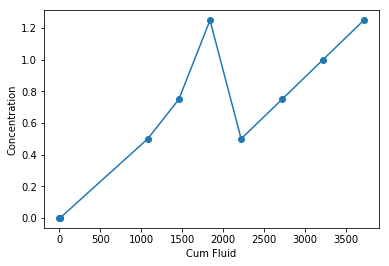

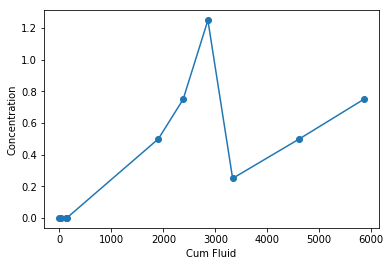

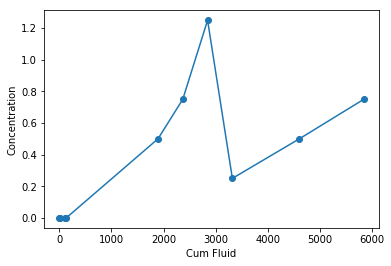

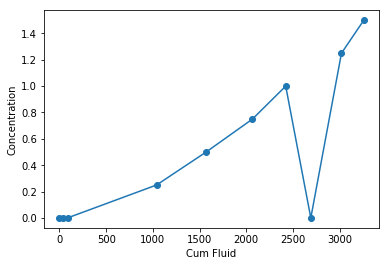

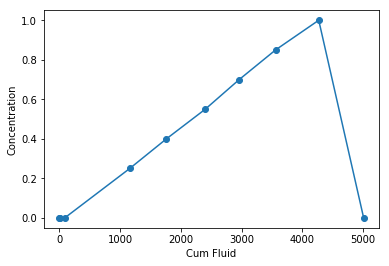

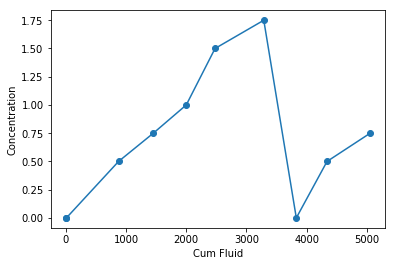

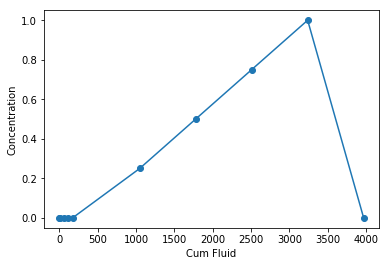

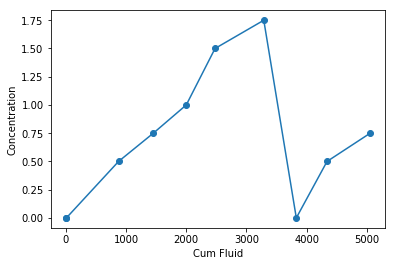

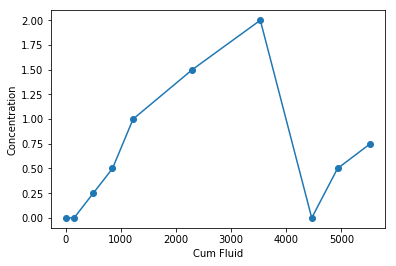

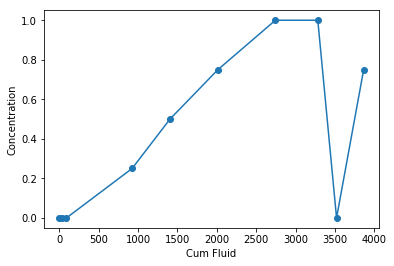

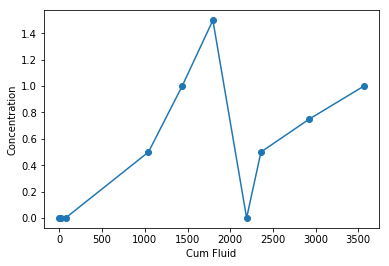

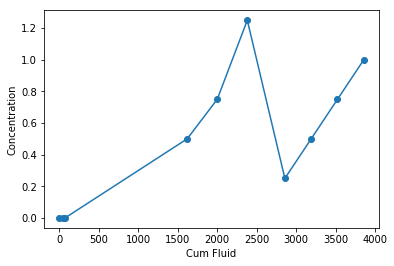

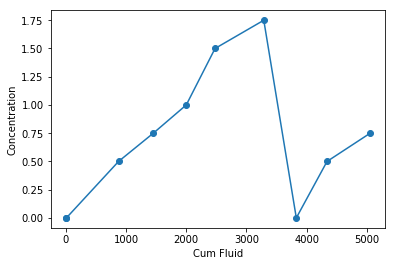

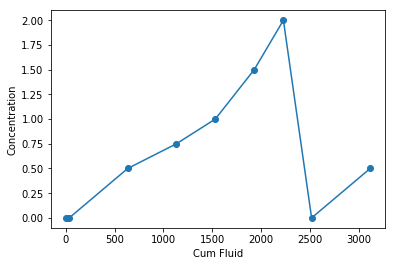

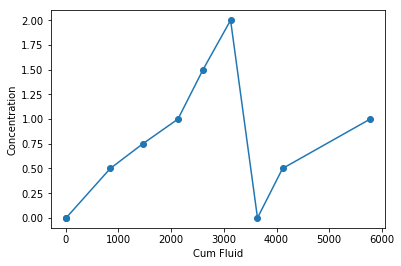

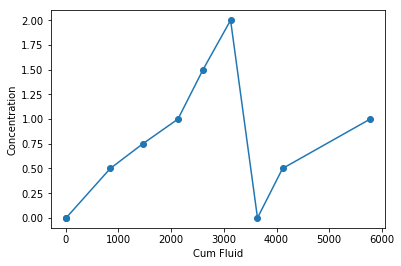

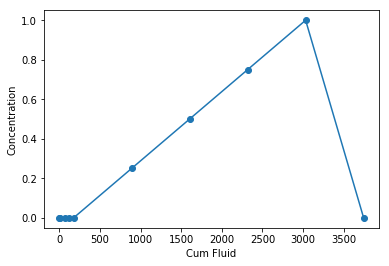

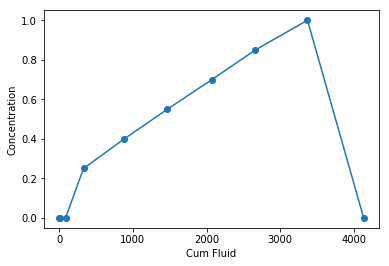

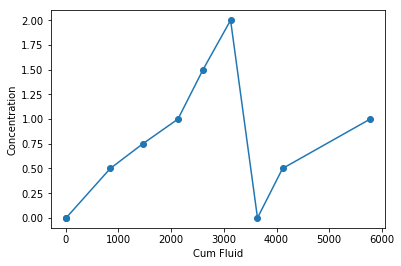

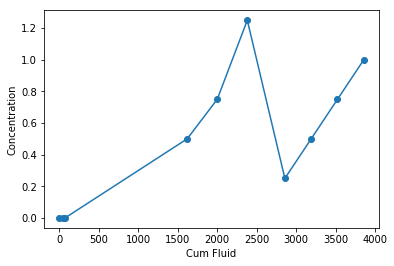

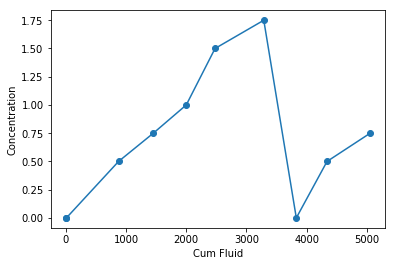

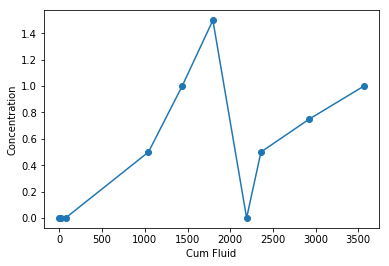

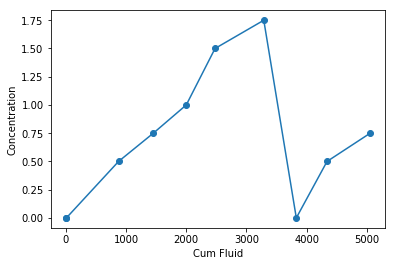

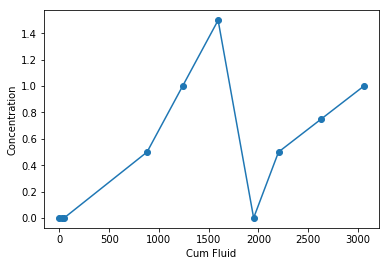

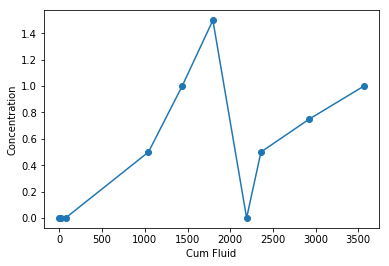

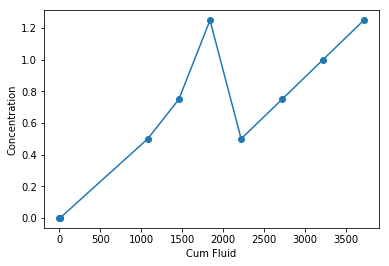

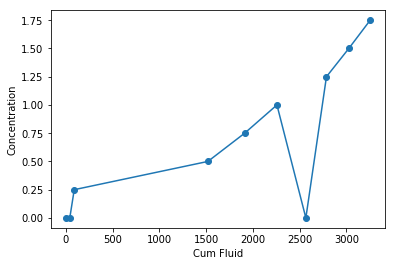

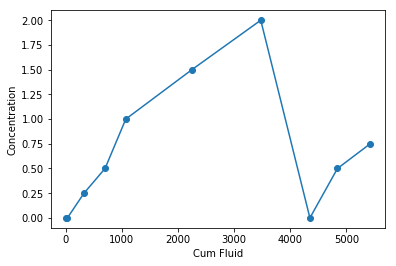

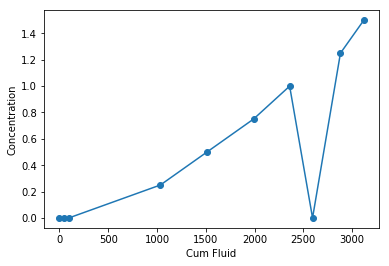

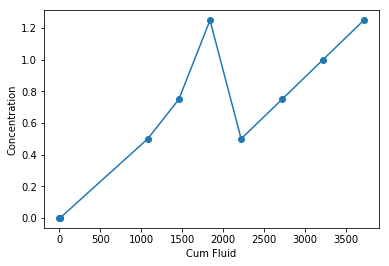

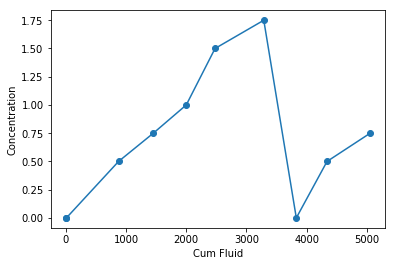

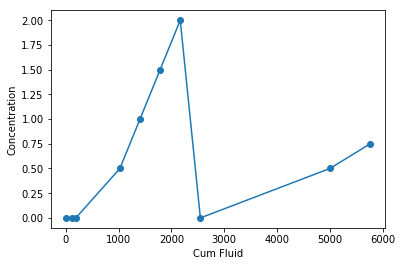

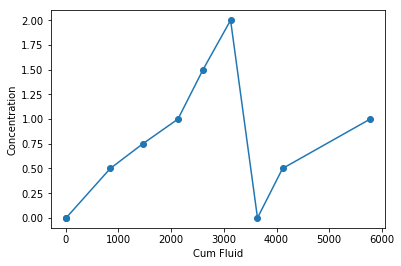

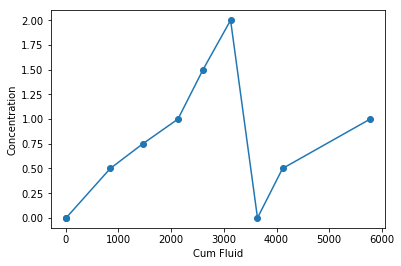

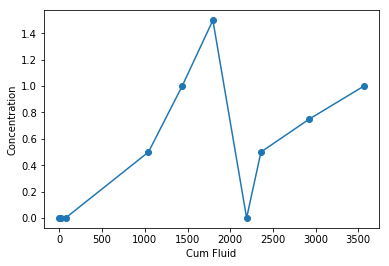

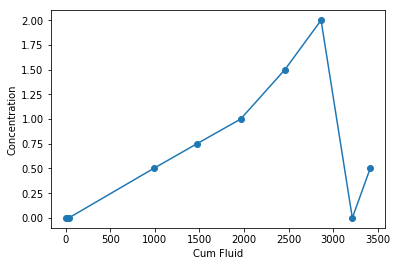

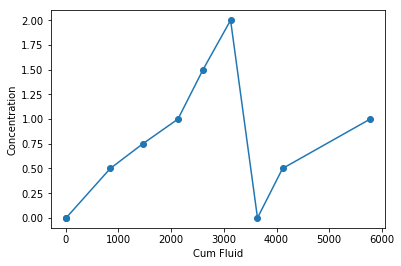

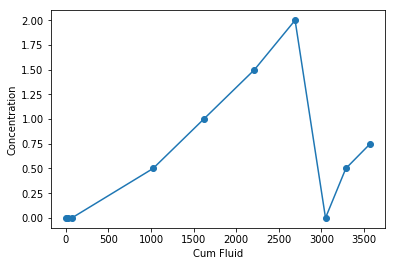

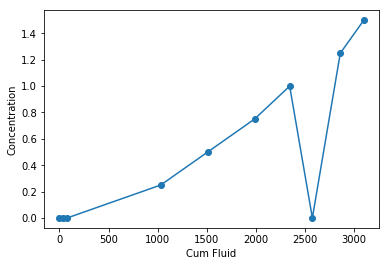

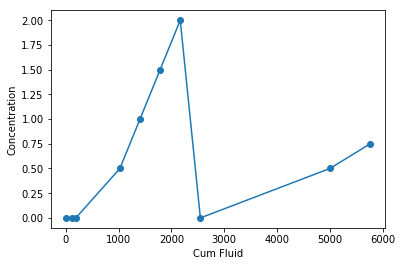

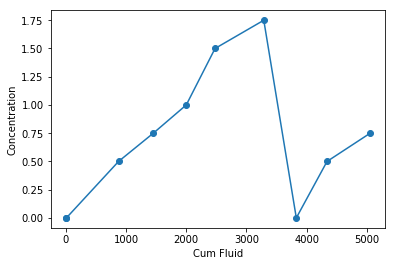

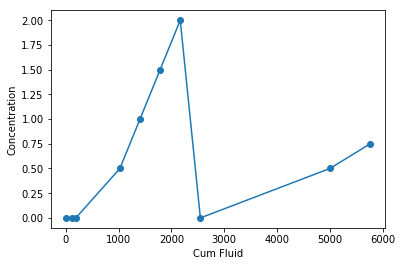

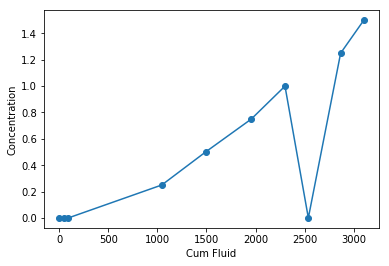

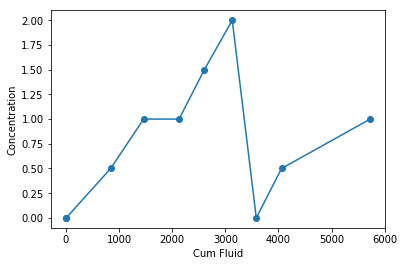

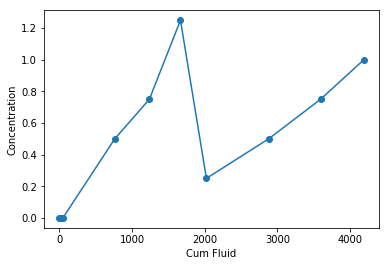

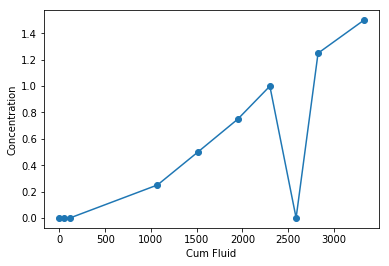

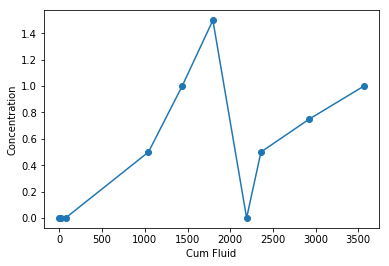

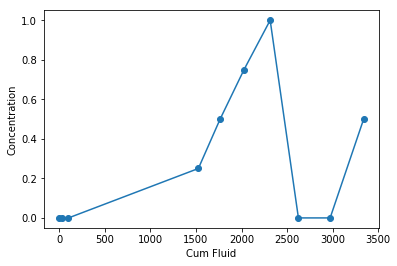

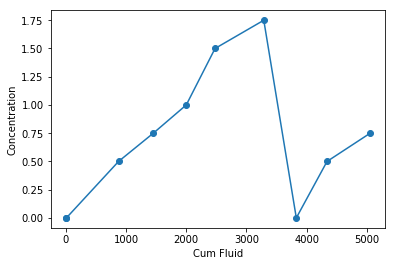

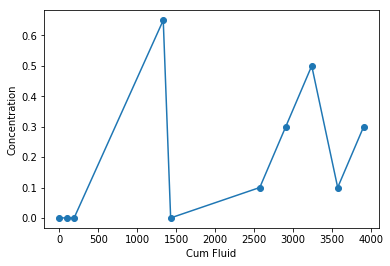

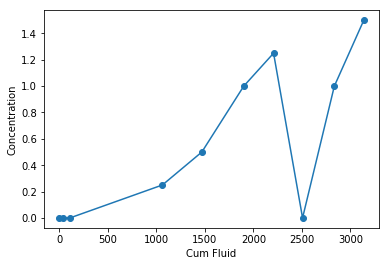

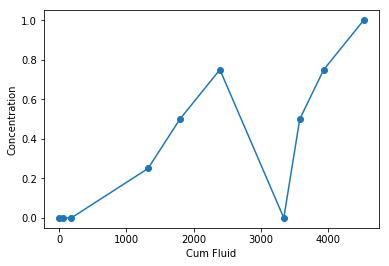

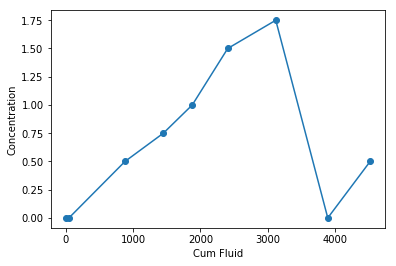

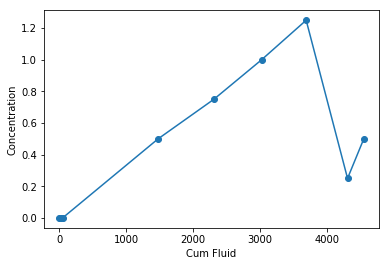

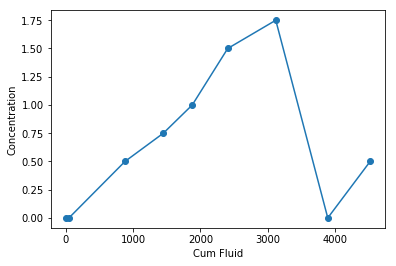

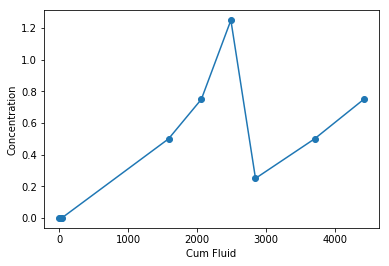

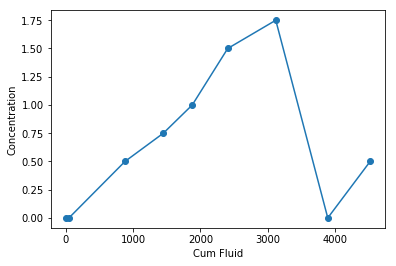

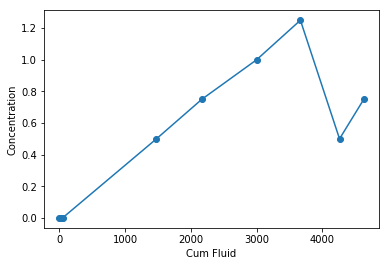

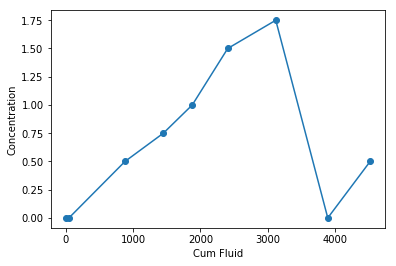

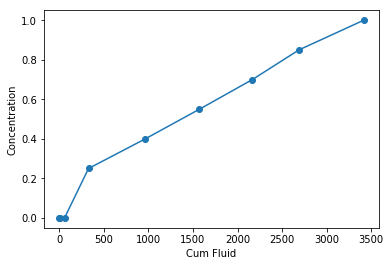

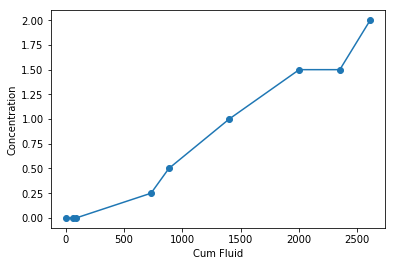

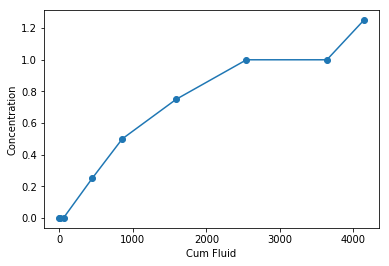

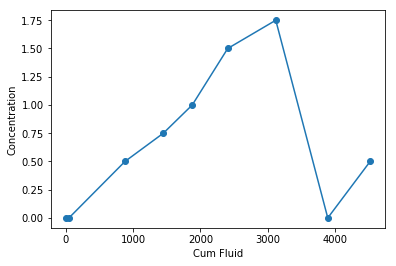

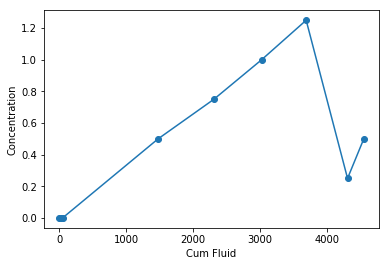

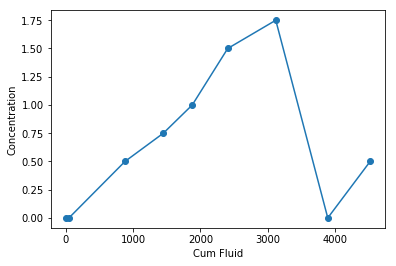

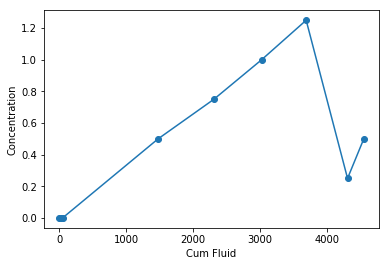

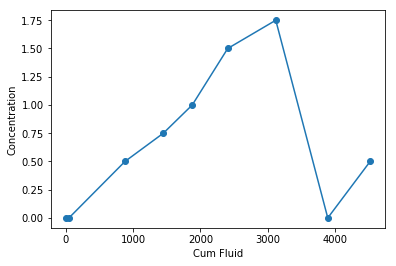

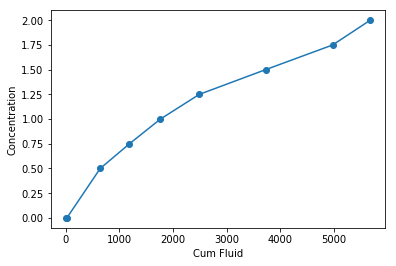

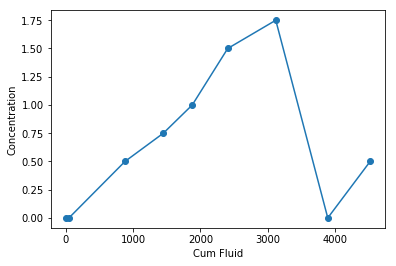

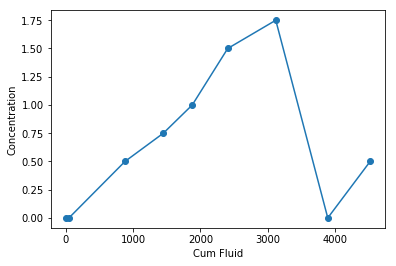

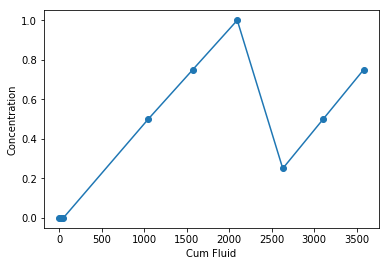

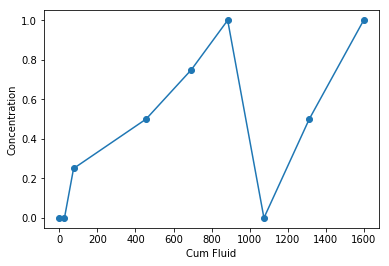

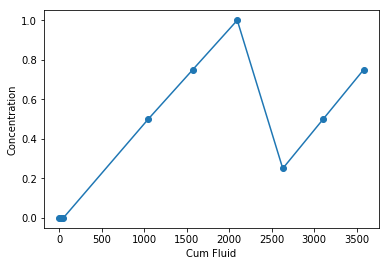

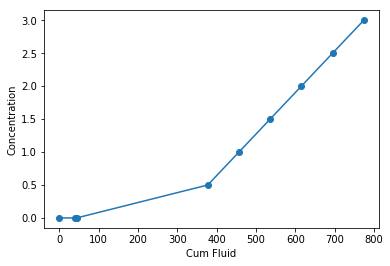

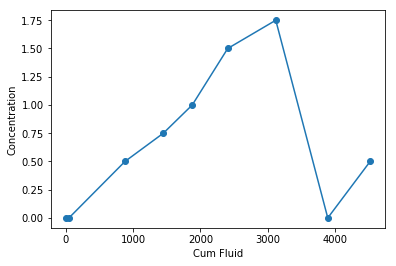

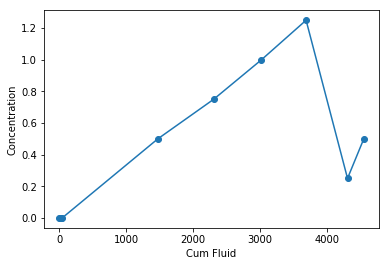

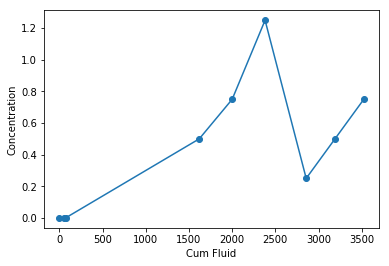

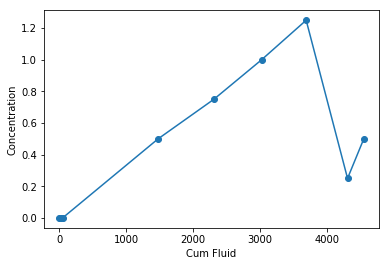

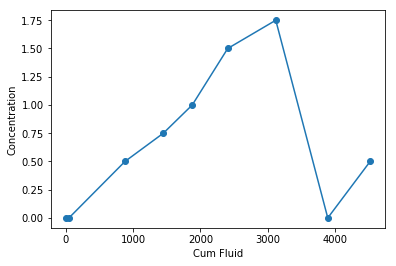

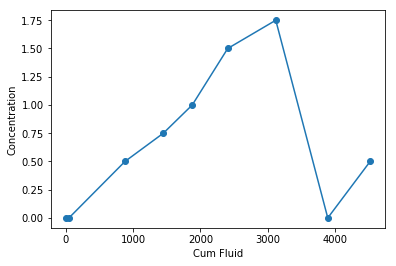

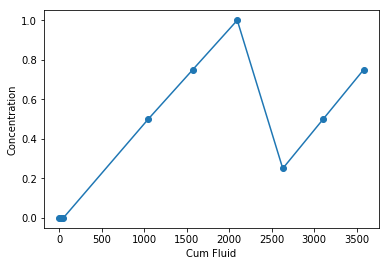

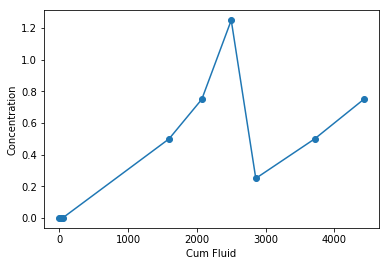

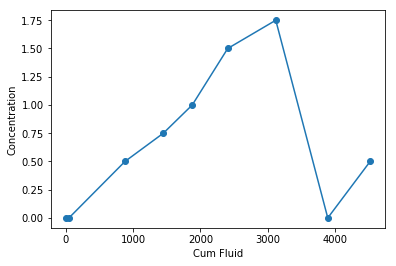

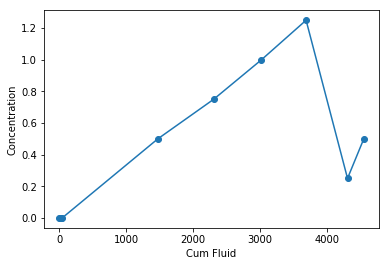

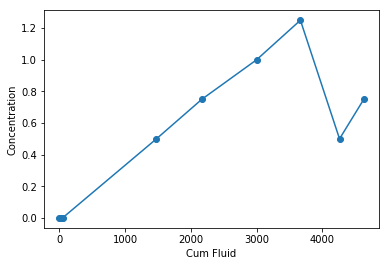

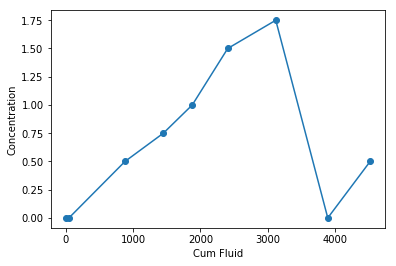

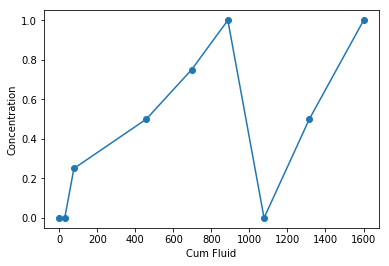

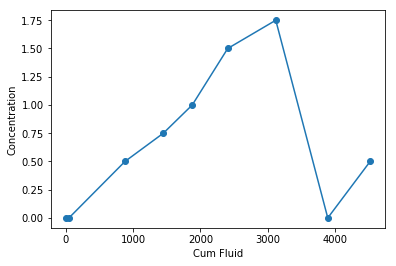

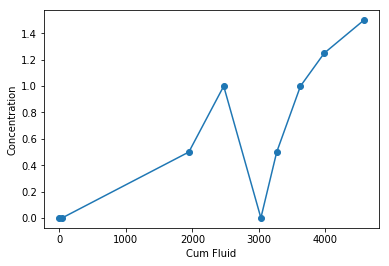

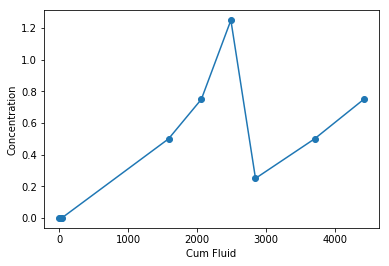

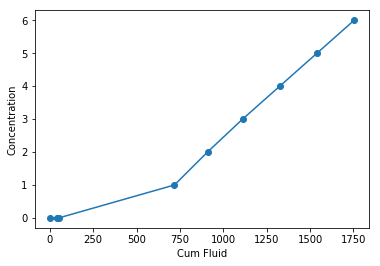

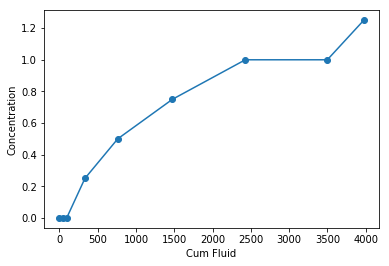

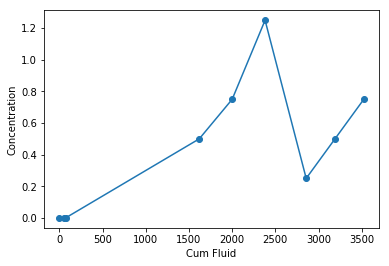

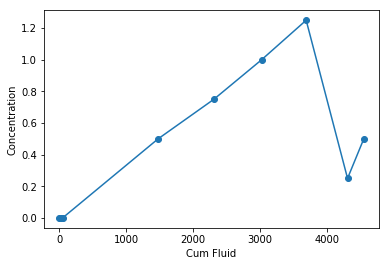

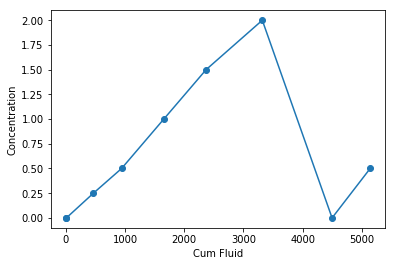

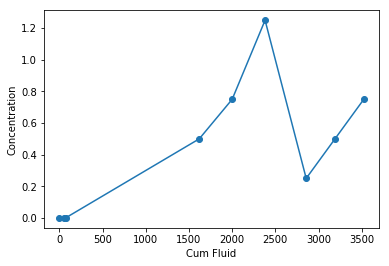

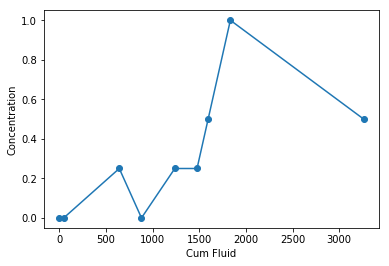

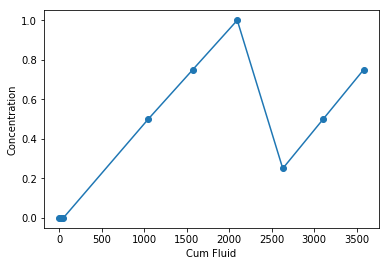

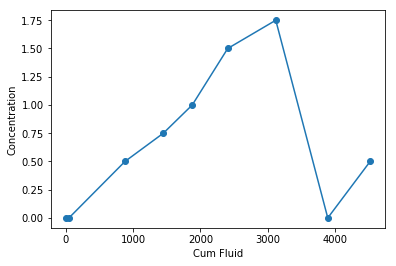

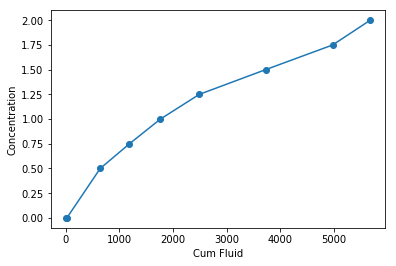

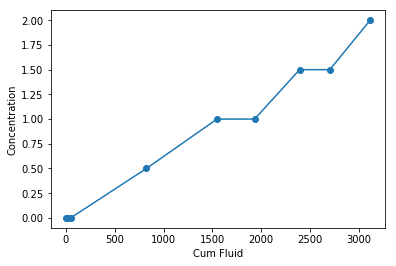

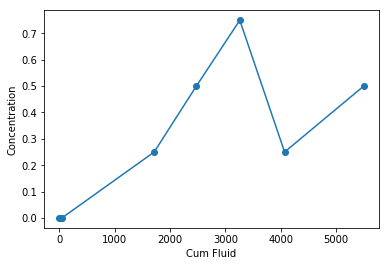

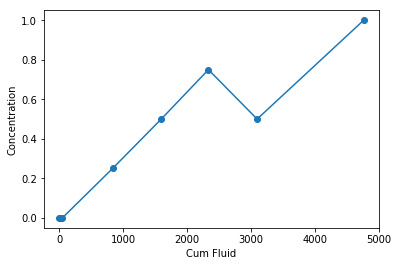

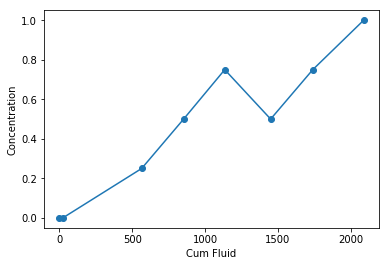

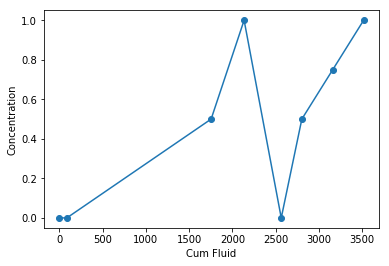

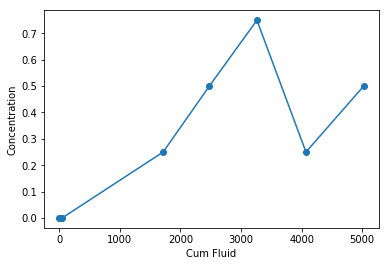

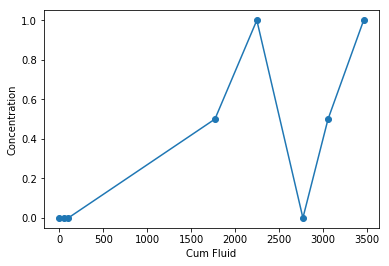

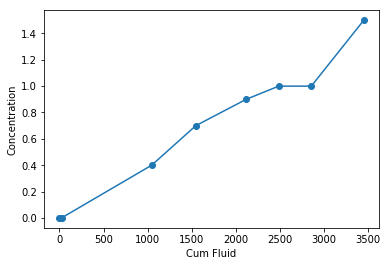

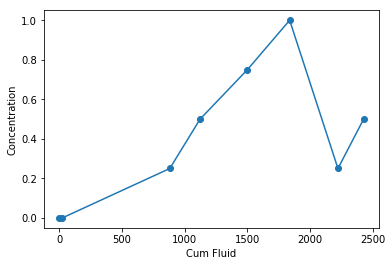

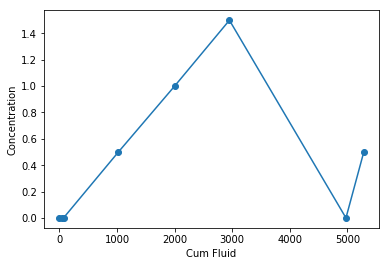

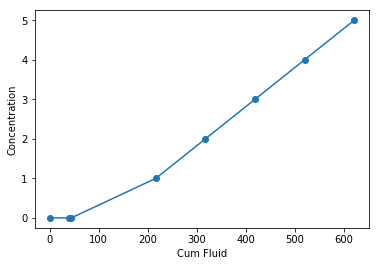

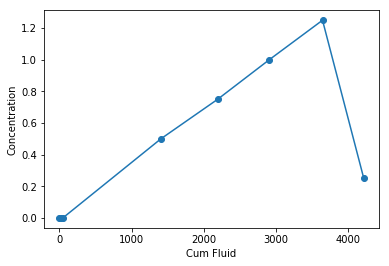

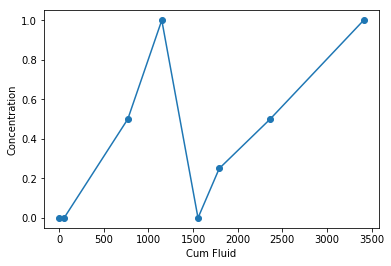

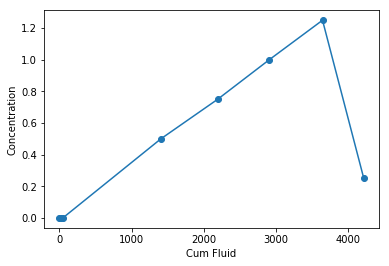

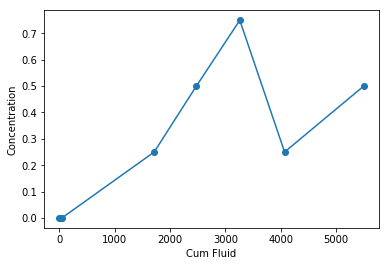

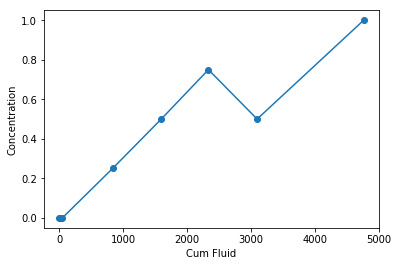

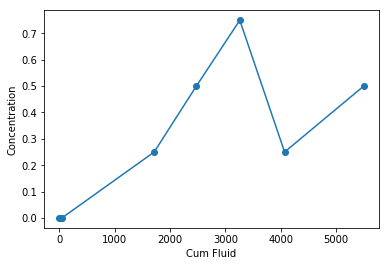

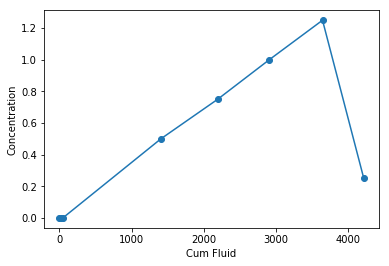

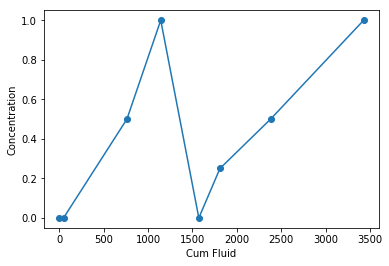

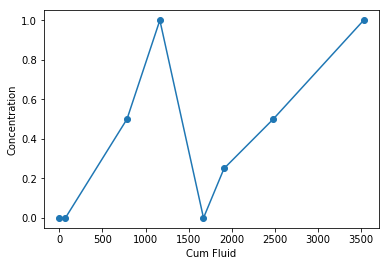

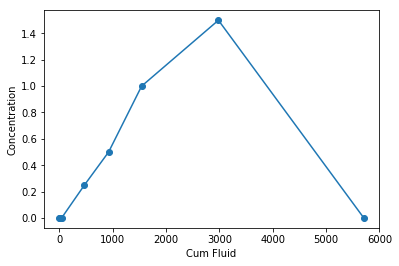

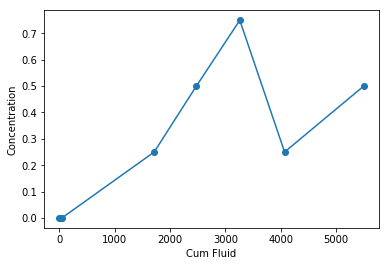

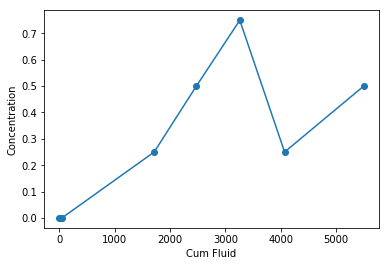

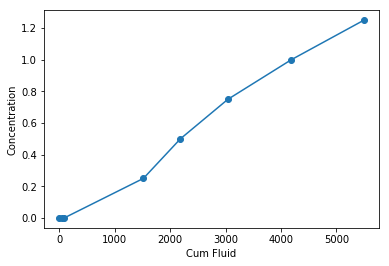

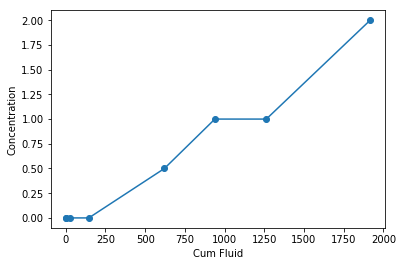

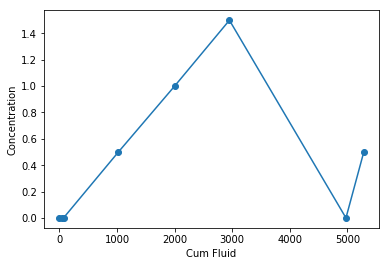

KeyboardInterrupt: 

In [110]:
for i,arr in enumerate(well_list):
    w = well_list[i]
    x = pump_final[pump_final['WELL_ID']==w].CUM_FLUID
    y = pump_final[pump_final['WELL_ID']==w].CONC
    plt.plot(x,y,'o-')
    plt.xlabel('Cum Fluid')
    plt.ylabel('Concentration')
    plt.show()

In [49]:
# What do the pump curves in each cluster look like?
# Filter pump_final data frame for wells in the same category
# Plot each pump curve as a subplot to visualize them all together

category_df

0 WELL_ID
0    8    1000
1    1    1001
2    1    1002
3    1    1003
4    1    1004
5    3    1005
6    1    1006
7    3    1007
8    1    1008
9    1    1009
10   1    1010
11   1    1011
12   1    1012
13   1    1013
14   1    1014
15   1    1015
16   1    1016
17   2    1017
18   3    1018
19   3    1019
20   8    1020
21   8    1021
22   4    1022
23   8    1023
24   9    1024
25   8    1025
26   8    1026
27   1    1027
28   1    1028
29   1    1029
..  ..     ...
678  1    1678
679  1    1679
680  1    1680
681  1    1681
682  1    1682
683  1    1683
684  1    1684
685  1    1685
686  1    1686
687  1    1687
688  7    1688
689  1    1689
690  1    1690
691  1    1691
692  1    1692
693  1    1693
694  1    1694
695  1    1695
696  1    1696
697  1    1697
698  1    1698
699  1    1699
700  1    1700
701  1    1701
702  1    1702
703  7    1703
704  1    1704
705  7    1705
706  1    1706
707  1    1707

[708 rows x 2 columns]

#### Next Steps:
- Use different clustering algorithms and examine results
    - DBSCAN
    - Hierarchical Clustering
    - Gaussian Mixture Model? http://scikit-learn.org/stable/modules/mixture.html
        - Takes into account correlations between features
        - Assumes order matters
        - Ref: https://brilliant.org/wiki/gaussian-mixture-model/
- Incorportate cluster label into company's MVR model